In [1]:
import sys
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

from datetime import date
from tensorflow.keras.models import model_from_json
from sklearn.model_selection import train_test_split


import pickle
import joblib
import time
import math
import timeit

In [2]:
#Split the data into two parts for training and prediction validation
import math
import joblib
training_data_whole = joblib.load(open('./data/case2data/original_data.pkl', 'rb'))
print(training_data_whole.shape)

two_dimension_data_0=training_data_whole.reshape(training_data_whole.shape[0],training_data_whole.shape[1]*2)[0:1601]
two_dimension_data=training_data_whole.reshape(training_data_whole.shape[0],training_data_whole.shape[1]*2)[1601:2001]

print(two_dimension_data_0.shape)
print(two_dimension_data.shape)

(2001, 55268, 2)
(1601, 110536)
(400, 110536)


In [3]:
#Using the POD to study the code length correspoonding with percentage of energy captured
import sklearn
from sklearn.decomposition import PCA
pca = PCA(n_components=0.90, svd_solver='full')
pca.fit(two_dimension_data_0)
print(pca.explained_variance_ratio_)
pca_data=pca.transform(two_dimension_data_0)
print(pca_data.shape)

[0.3785023  0.26103692 0.19093161 0.02598685 0.02164349 0.01830285
 0.01618016]
(1601, 7)


/home/chuanhua/Experiments/ROM_LSTM
time spend for reduction: 14.189771694000228
Reconstruction Error (Normalized Frobenius Norm): 0.1065
time spend for reduction: 16.528375062000123
Reconstruction Error (Normalized Frobenius Norm): 0.0775
time spend for reduction: 18.8003904090001
Reconstruction Error (Normalized Frobenius Norm): 0.0355


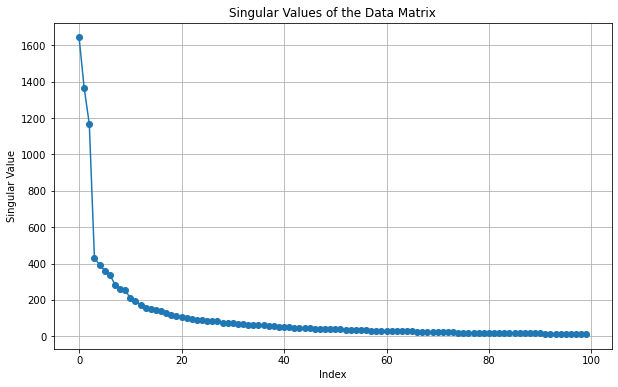

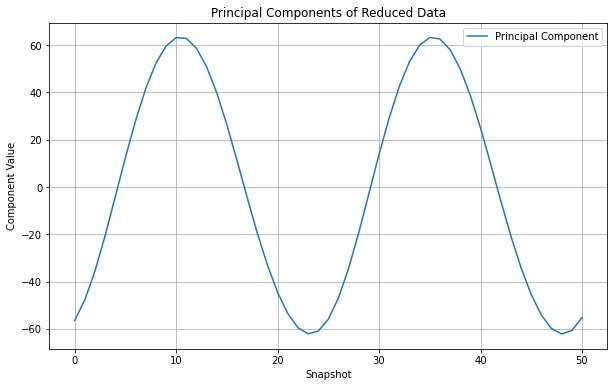

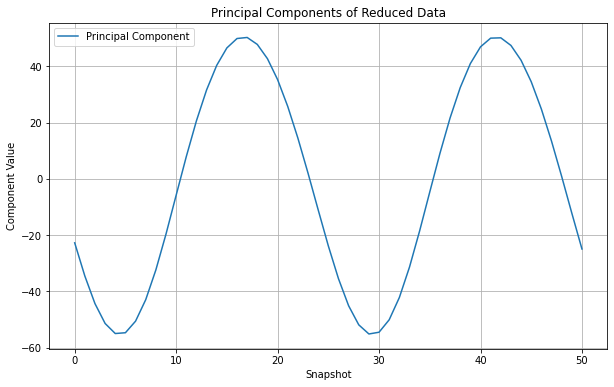

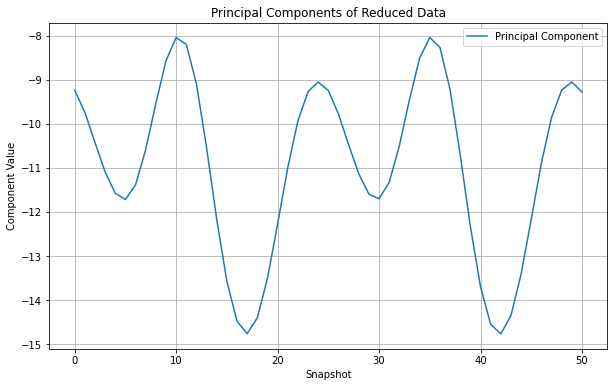

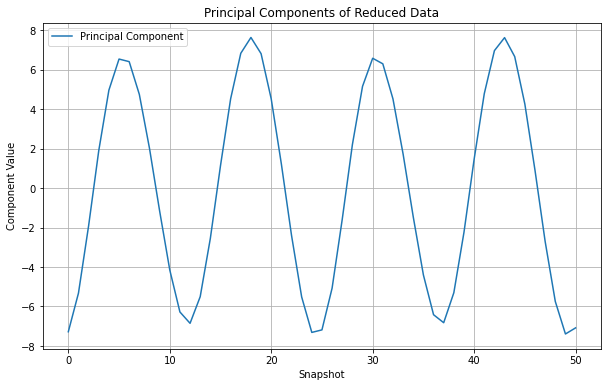

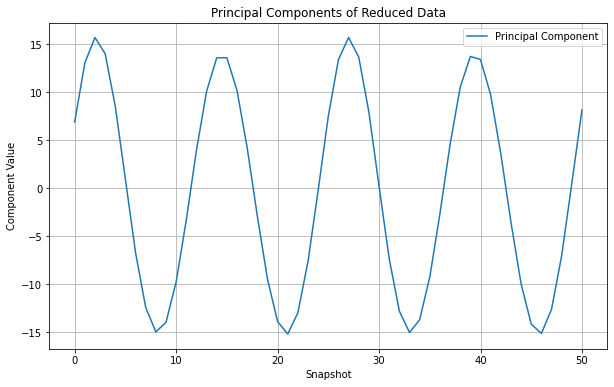

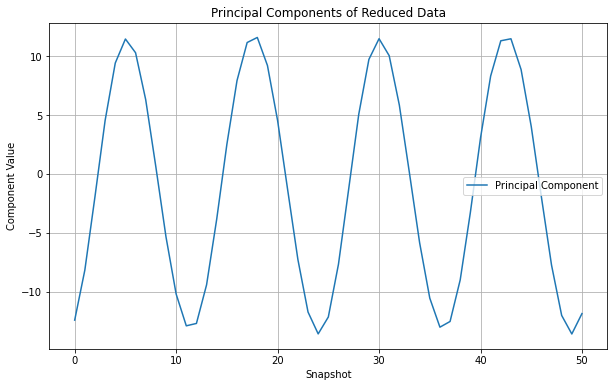

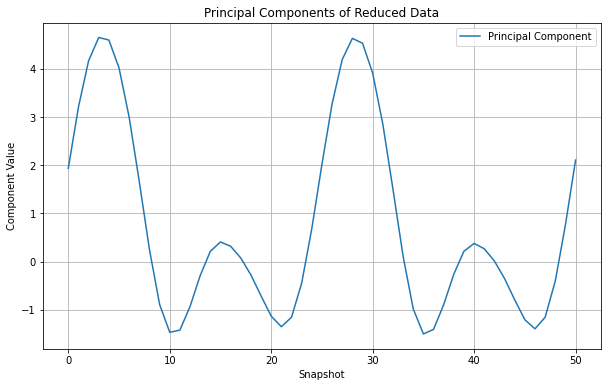

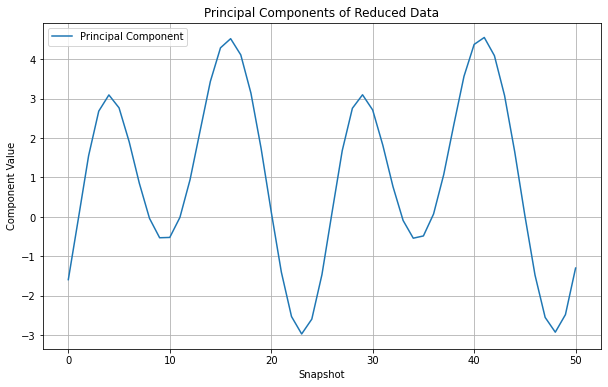

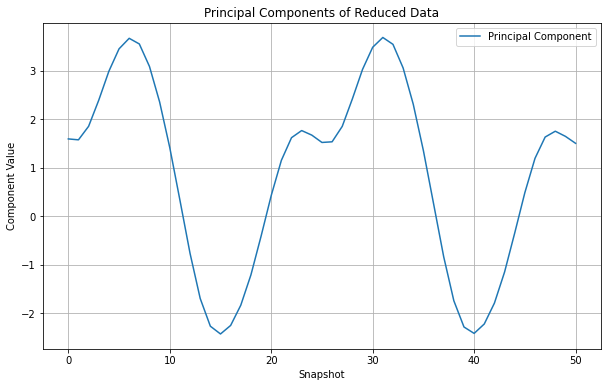

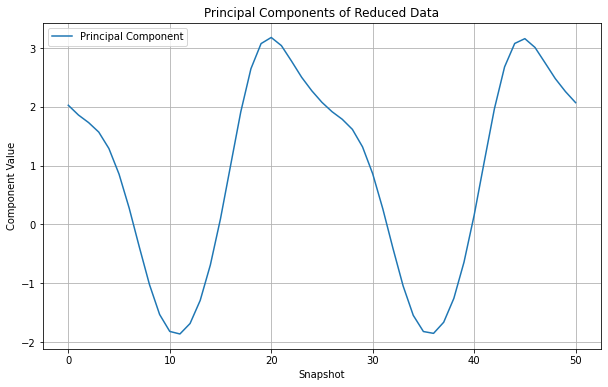

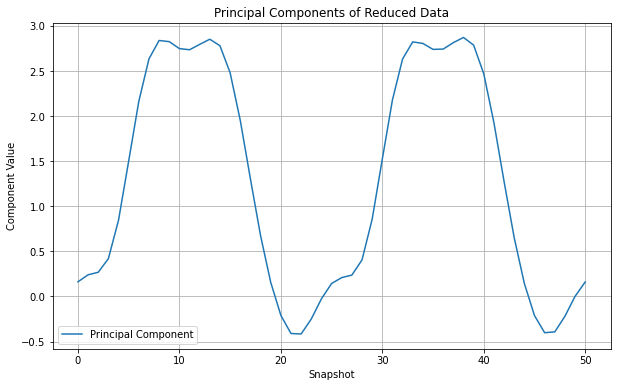

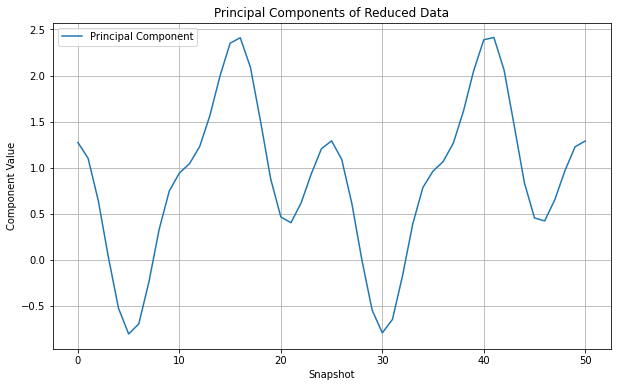

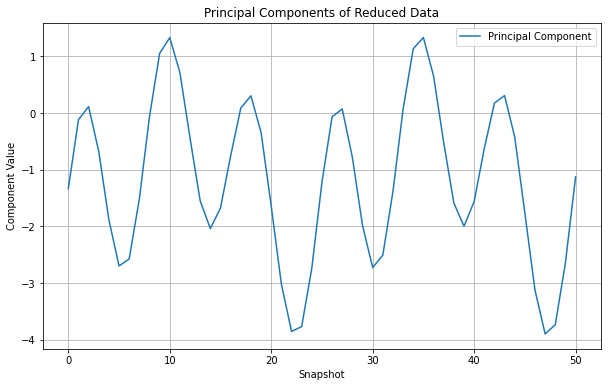

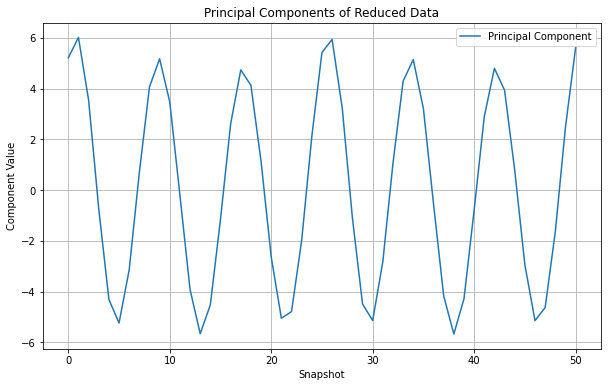

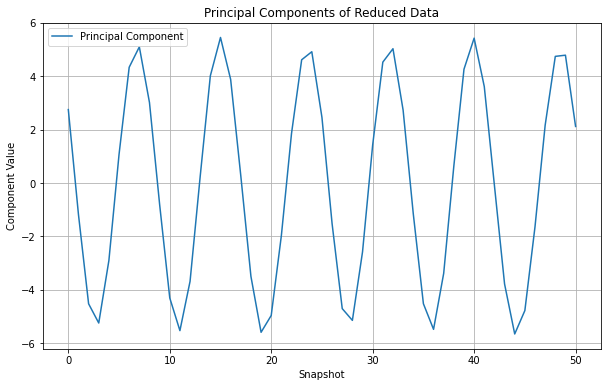

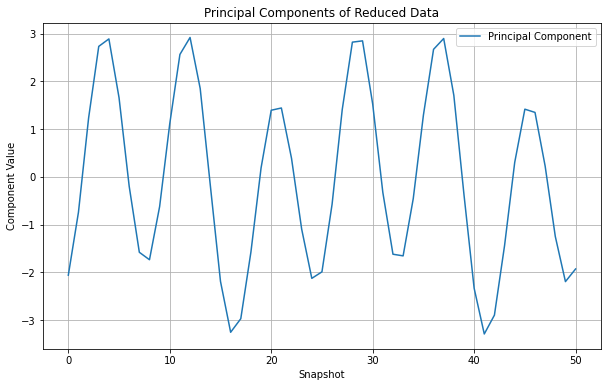

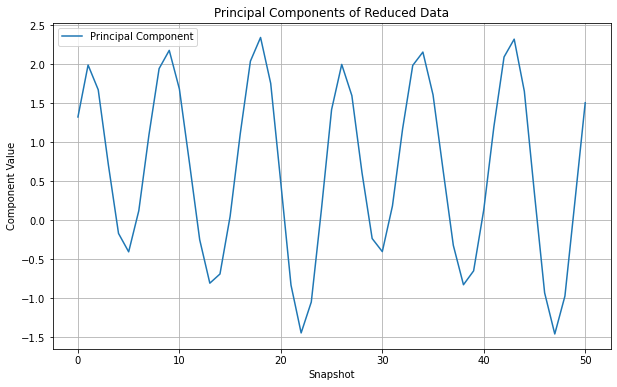

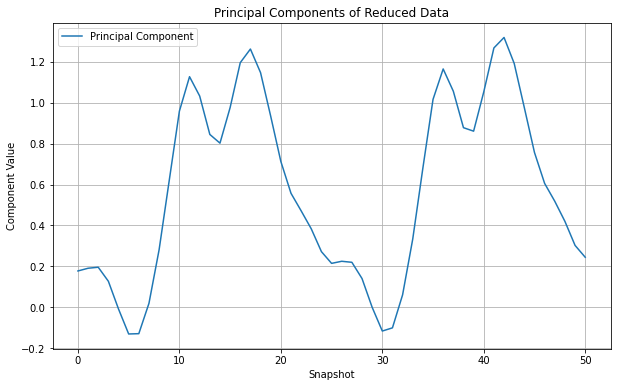

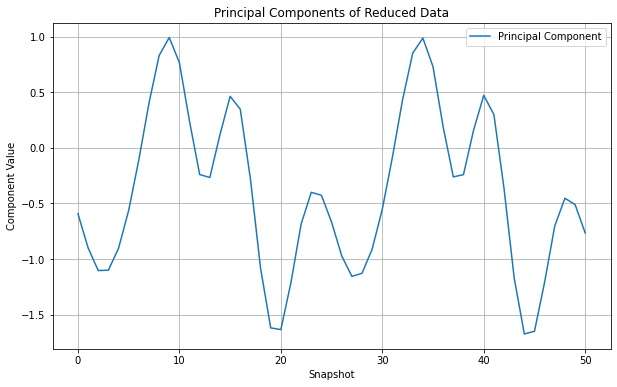

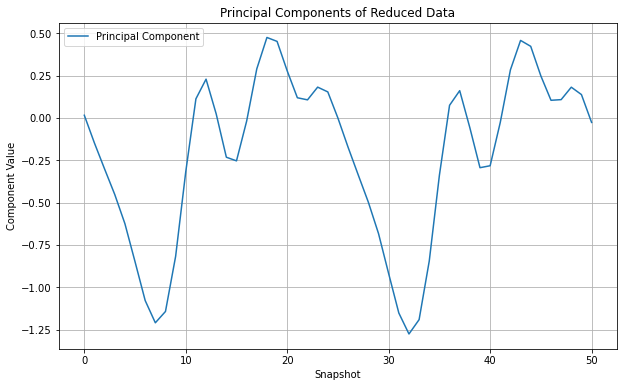

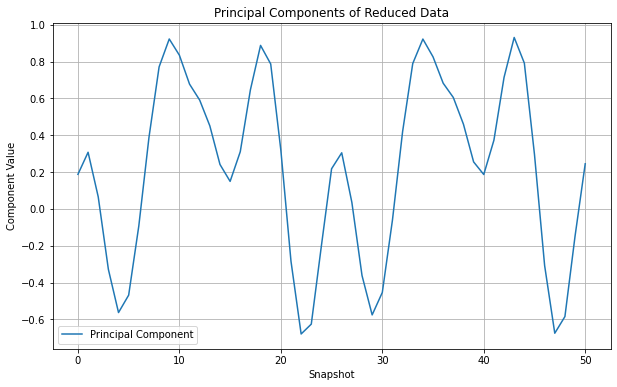

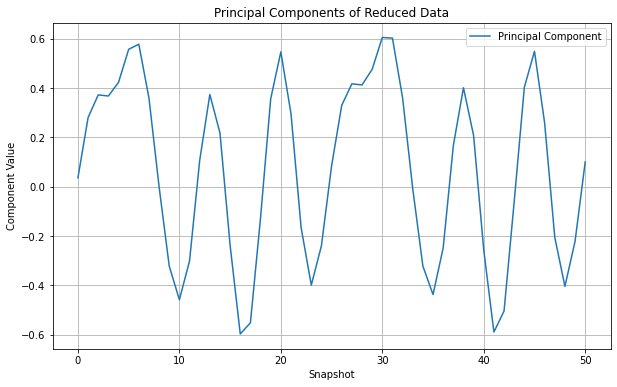

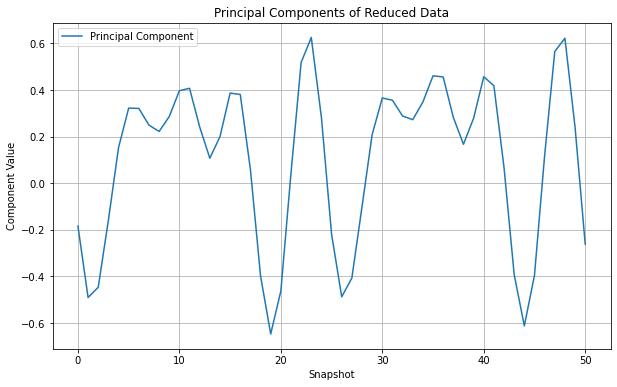

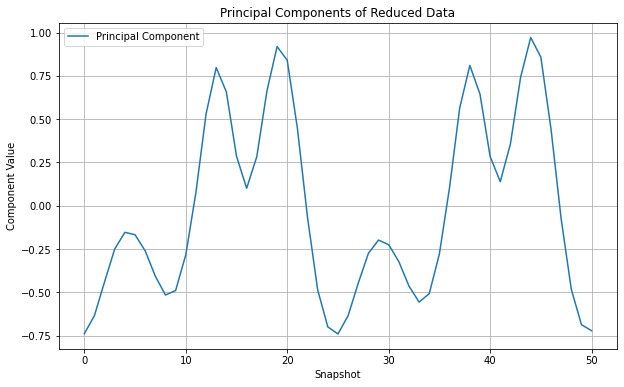

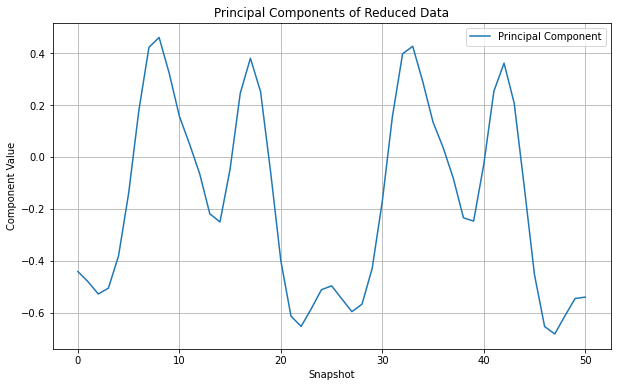

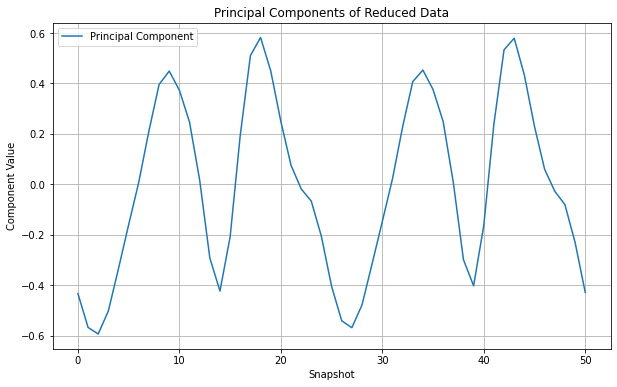

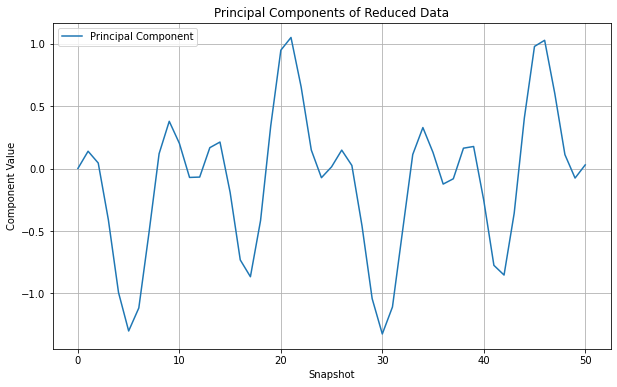

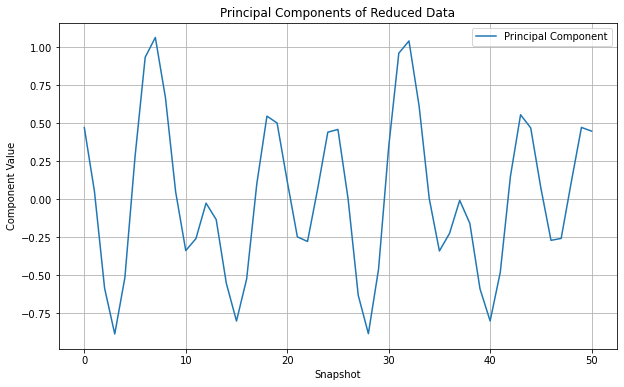

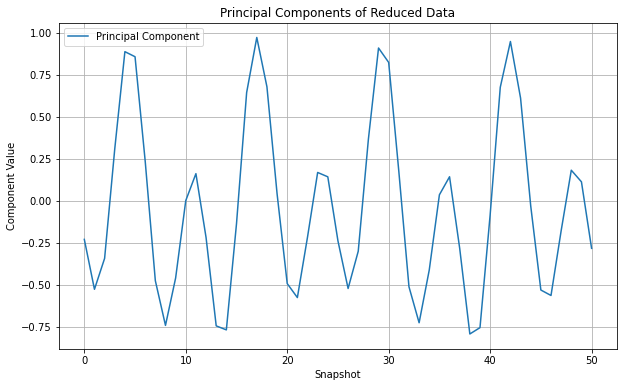

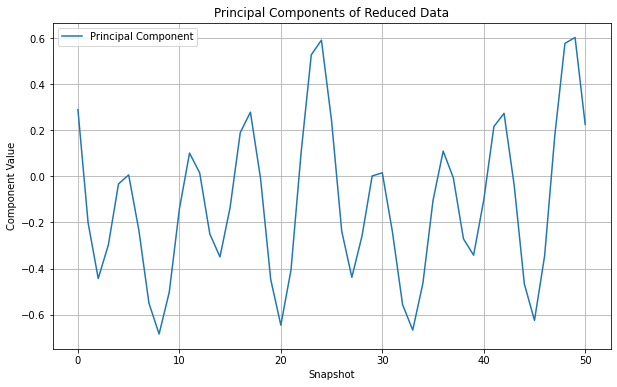

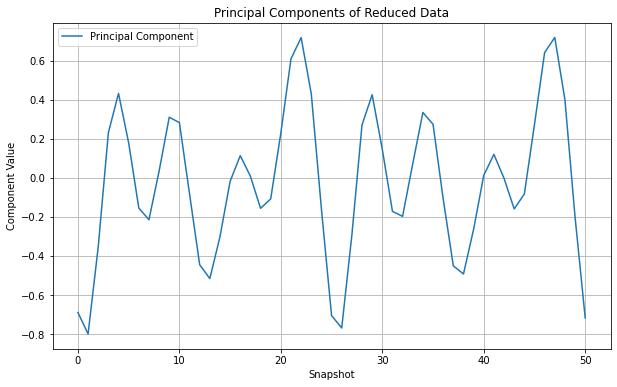

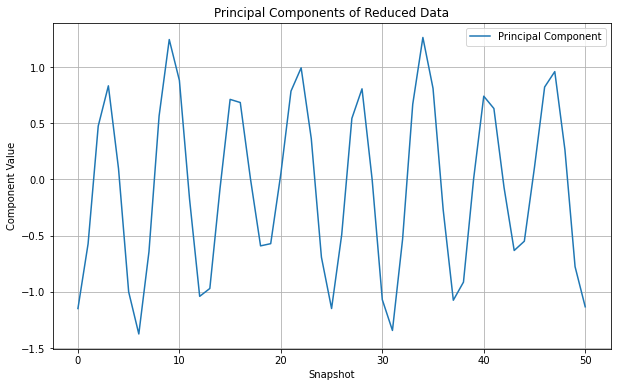

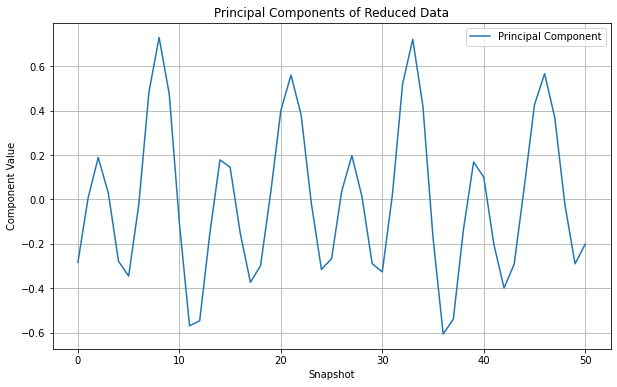

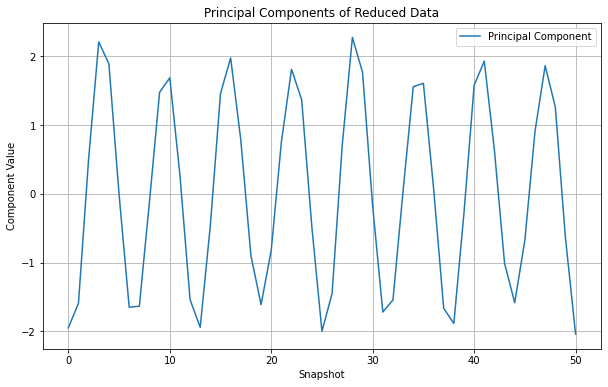

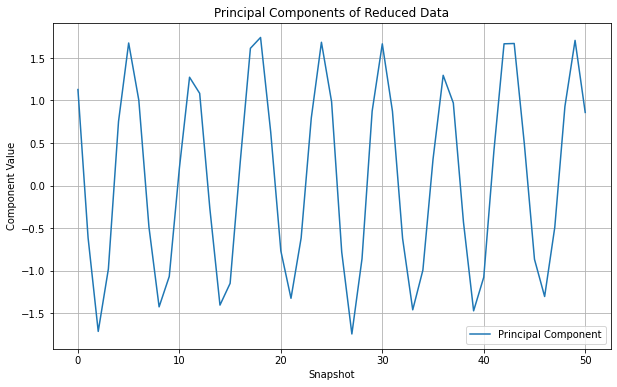

In [3]:
#POD model for comparison with SAE to display the effectiveness of SAE in order reduce.
print(os.getcwd()) 

# Step 1: Prepare the Data
data = two_dimension_data_0  


#start time
start_time=timeit.default_timer()
# Step 2: Compute the Mean
mean_data = np.mean(data, axis=0)  # Mean of each column (feature)

# Step 3: Center the Data
data_centered = data - mean_data

# Step 4: Compute the Covariance Matrix
# Note: In practice, for large data, we often use a different method to compute the SVD directly.
U, S, Vt = np.linalg.svd(data_centered, full_matrices=False)

# U is (1600, 1600), S is (1600,), Vt is (1600, 110536)

# Step 5: Compute POD Modes (Principal Components)
# Select the top k components

k_collection = [7,12,35]  # Number of principal components to keep (hyperparameter, change as needed)
for k in k_collection:
    POD_modes = Vt[:k, :]  # Top k POD modes

    # Step 6: Project the Data onto the Reduced Dimensional Space
    # This gives us the reduced data representation in the lower-dimensional space
    data_reduced = np.dot(data_centered, POD_modes.T)
    pickle.dump(data_reduced, open("./Temp_data_Case2/reduced_data_" + str(k) + "_POD.pkl", "wb"))

    #end time
    end_time=timeit.default_timer()
    print("time spend for reduction:",end_time - start_time)

    # Step 7: Reconstruct the Data (Optional, to evaluate effectiveness)
    # This is done by projecting back to the original space
    data_reconstructed = np.dot(data_reduced, POD_modes) + mean_data
    pickle.dump(data_reconstructed, open("./Temp_data_Case2/reconstructed_data_" + str(k) + "_POD.pkl", "wb"))

    # Step 8: Evaluate Reconstruction Error (Optional)
    reconstruction_error = np.linalg.norm(data - data_reconstructed) / np.linalg.norm(data)
    print(f"Reconstruction Error (Normalized Frobenius Norm): {reconstruction_error:.4f}")

# Step 9: Visualize the Singular Values
plt.figure(figsize=(10, 6))
plt.plot(S[:100], marker='o')
plt.title('Singular Values of the Data Matrix')
plt.xlabel('Index')
plt.ylabel('Singular Value')
plt.grid(True)
plt.show()

# Step 10: Visualize the Data Reduction
data_reduced = joblib.load(open("./Temp_data_Case2/reduced_data_" + str(k) + "_POD.pkl",'rb'))
for idx in range(data_reduced.shape[1]):
    plt.figure(figsize=(10, 6))
    plt.plot(data_reduced[1550:, idx], label='Principal Component')
    plt.title('Principal Components of Reduced Data')
    plt.xlabel('Snapshot')
    plt.ylabel('Component Value')
    plt.legend()
    plt.grid(True)
    plt.show()

# ***SAE Model***

In [3]:
#Import SAE model
from dmd_machine.SAE import *
scaled_data=two_dimension_data_0
print(scaled_data.shape)
pred_time_steps=400

(1601, 110536)


# **Train AE model**

In [107]:
#Train the SAE model
from sklearn.model_selection import train_test_split

model_save_folder = './AE_Models_case2'

encoding_dim_array=[7,12,35]#90%,95%,99%
time_spending=[]
for encoding_dim in encoding_dim_array:    
    #start time
    start_time=timeit.default_timer()
    
    encoder_file_name = 'AE_encoder_dim' + str(encoding_dim) # name of encoder model
    decoder_file_name = 'AE_decoder_dim' + str(encoding_dim) # name of decoder model
    AE_file_name = 'AE_dim' + str(encoding_dim) # name of AE whole model
    
    batch_size = 32
    epochs = 300

    train_set, test = train_test_split(scaled_data, test_size=0.2, random_state=1)
    train, validation = train_test_split(train_set, test_size=0.1, random_state=2)
    print(train.shape)

    ae = StackAutoencoder()

    if os.path.exists(model_save_folder + "/" + AE_file_name):

        ae.autoencoder = load_model(model_save_folder + "/" + AE_file_name)
        ae.encoder = load_model(model_save_folder + "/" + encoder_file_name)
        ae.decoder = load_model(model_save_folder + "/" + decoder_file_name)

        ae.autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
        ae.autoencoder.summary()

        ae.train_model(train, validation, test, epochs, batch_size, model_save_folder, encoder_file_name, decoder_file_name, AE_file_name)


    else:
        ae.load_model(train, encoding_dim)
        ae.autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
        ae.autoencoder.summary()
        
        ae.train_model(train, validation, test, epochs, batch_size, model_save_folder, encoder_file_name, decoder_file_name, AE_file_name)

    #end time
    end_time=timeit.default_timer()
    print("time spend for prediction:",end_time - start_time)
    time_spending.append(end_time - start_time)
print("time_spending",time_spending)

(1152, 110536)
Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 110536)]          0         
_________________________________________________________________
encoder (Functional)         (None, 7)                 6192179   
_________________________________________________________________
decoder (Functional)         (None, 110536)            6302708   
Total params: 12,494,887
Trainable params: 12,494,887
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
36/36 [==============================] - 1s 34ms/step - loss: 0.0465 - accuracy: 0.0000e+00 - val_loss: 0.0384 - val_accuracy: 0.0000e+00

Epoch 00001: val_loss improved from inf to 0.03844, saving model to ./AE_Models_case3/AE_dim7
INFO:tensorflow:Assets written to: ./AE_Models_case3/AE_dim7/assets
Epoch 2/300
36/36 [==========================

INFO:tensorflow:Assets written to: ./AE_Models_case3/AE_dim7/assets
Epoch 25/300
36/36 [==============================] - 1s 32ms/step - loss: 0.0024 - accuracy: 0.0000e+00 - val_loss: 0.0030 - val_accuracy: 0.0000e+00

Epoch 00025: val_loss improved from 0.00305 to 0.00302, saving model to ./AE_Models_case3/AE_dim7
INFO:tensorflow:Assets written to: ./AE_Models_case3/AE_dim7/assets
Epoch 26/300
36/36 [==============================] - 1s 32ms/step - loss: 0.0024 - accuracy: 0.0000e+00 - val_loss: 0.0029 - val_accuracy: 0.0000e+00

Epoch 00026: val_loss improved from 0.00302 to 0.00293, saving model to ./AE_Models_case3/AE_dim7
INFO:tensorflow:Assets written to: ./AE_Models_case3/AE_dim7/assets
Epoch 27/300
36/36 [==============================] - 1s 32ms/step - loss: 0.0024 - accuracy: 0.0000e+00 - val_loss: 0.0030 - val_accuracy: 0.0000e+00

Epoch 00027: val_loss did not improve from 0.00293
Epoch 28/300
36/36 [==============================] - 1s 32ms/step - loss: 0.0023 - accuracy:

INFO:tensorflow:Assets written to: ./AE_Models_case3/AE_dim7/assets
Epoch 56/300
36/36 [==============================] - 1s 31ms/step - loss: 0.0015 - accuracy: 8.6806e-04 - val_loss: 0.0017 - val_accuracy: 0.0000e+00

Epoch 00056: val_loss improved from 0.00179 to 0.00167, saving model to ./AE_Models_case3/AE_dim7
INFO:tensorflow:Assets written to: ./AE_Models_case3/AE_dim7/assets
Epoch 57/300
36/36 [==============================] - 1s 31ms/step - loss: 0.0015 - accuracy: 8.6806e-04 - val_loss: 0.0018 - val_accuracy: 0.0000e+00

Epoch 00057: val_loss did not improve from 0.00167
Epoch 58/300
36/36 [==============================] - 1s 31ms/step - loss: 0.0016 - accuracy: 8.6806e-04 - val_loss: 0.0020 - val_accuracy: 0.0000e+00

Epoch 00058: val_loss did not improve from 0.00167
Epoch 59/300
36/36 [==============================] - 1s 32ms/step - loss: 0.0017 - accuracy: 0.0000e+00 - val_loss: 0.0018 - val_accuracy: 0.0000e+00

Epoch 00059: val_loss did not improve from 0.00167
Epoch


Epoch 00089: val_loss did not improve from 0.00142
Epoch 90/300
36/36 [==============================] - 1s 32ms/step - loss: 0.0012 - accuracy: 0.0104 - val_loss: 0.0015 - val_accuracy: 0.0000e+00

Epoch 00090: val_loss did not improve from 0.00142
Epoch 91/300
36/36 [==============================] - 1s 31ms/step - loss: 0.0012 - accuracy: 0.0069 - val_loss: 0.0014 - val_accuracy: 0.0000e+00

Epoch 00091: val_loss improved from 0.00142 to 0.00139, saving model to ./AE_Models_case3/AE_dim7
INFO:tensorflow:Assets written to: ./AE_Models_case3/AE_dim7/assets
Epoch 92/300
36/36 [==============================] - 1s 31ms/step - loss: 0.0012 - accuracy: 0.0174 - val_loss: 0.0014 - val_accuracy: 0.0000e+00

Epoch 00092: val_loss did not improve from 0.00139
Epoch 93/300
36/36 [==============================] - 1s 31ms/step - loss: 0.0012 - accuracy: 0.0061 - val_loss: 0.0014 - val_accuracy: 0.0000e+00

Epoch 00093: val_loss did not improve from 0.00139
Epoch 94/300
36/36 [=================

36/36 [==============================] - 1s 31ms/step - loss: 9.9733e-04 - accuracy: 0.0278 - val_loss: 0.0013 - val_accuracy: 0.0000e+00

Epoch 00159: val_loss did not improve from 0.00125
Epoch 160/300
36/36 [==============================] - 1s 32ms/step - loss: 9.9814e-04 - accuracy: 0.0260 - val_loss: 0.0013 - val_accuracy: 0.0000e+00

Epoch 00160: val_loss did not improve from 0.00125
Epoch 161/300
36/36 [==============================] - 1s 32ms/step - loss: 9.9708e-04 - accuracy: 0.0269 - val_loss: 0.0013 - val_accuracy: 0.0000e+00

Epoch 00161: val_loss improved from 0.00125 to 0.00125, saving model to ./AE_Models_case3/AE_dim7
INFO:tensorflow:Assets written to: ./AE_Models_case3/AE_dim7/assets
Epoch 162/300
36/36 [==============================] - 1s 32ms/step - loss: 9.9566e-04 - accuracy: 0.0269 - val_loss: 0.0013 - val_accuracy: 0.0000e+00

Epoch 00162: val_loss did not improve from 0.00125
Epoch 163/300
36/36 [==============================] - 1s 32ms/step - loss: 9.9573e

36/36 [==============================] - 1s 31ms/step - loss: 9.8716e-04 - accuracy: 0.0269 - val_loss: 0.0013 - val_accuracy: 0.0000e+00

Epoch 00195: val_loss did not improve from 0.00125
Epoch 196/300
36/36 [==============================] - 1s 31ms/step - loss: 9.8708e-04 - accuracy: 0.0269 - val_loss: 0.0012 - val_accuracy: 0.0000e+00

Epoch 00196: val_loss did not improve from 0.00125
Epoch 197/300
36/36 [==============================] - 1s 31ms/step - loss: 9.8707e-04 - accuracy: 0.0269 - val_loss: 0.0012 - val_accuracy: 0.0000e+00

Epoch 00197: val_loss did not improve from 0.00125

Epoch 00197: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.
Epoch 198/300
36/36 [==============================] - 1s 31ms/step - loss: 9.8693e-04 - accuracy: 0.0269 - val_loss: 0.0012 - val_accuracy: 0.0000e+00

Epoch 00198: val_loss did not improve from 0.00125
Epoch 199/300
36/36 [==============================] - 1s 32ms/step - loss: 9.8692e-04 - accuracy: 0.0269 - val_loss:

36/36 [==============================] - 1s 31ms/step - loss: 9.8657e-04 - accuracy: 0.0269 - val_loss: 0.0012 - val_accuracy: 0.0000e+00

Epoch 00269: val_loss did not improve from 0.00125
Epoch 270/300
36/36 [==============================] - 1s 31ms/step - loss: 9.8657e-04 - accuracy: 0.0269 - val_loss: 0.0012 - val_accuracy: 0.0000e+00

Epoch 00270: val_loss did not improve from 0.00125
Epoch 271/300
36/36 [==============================] - 1s 31ms/step - loss: 9.8657e-04 - accuracy: 0.0269 - val_loss: 0.0012 - val_accuracy: 0.0000e+00

Epoch 00271: val_loss did not improve from 0.00125
Epoch 272/300
36/36 [==============================] - 1s 32ms/step - loss: 9.8657e-04 - accuracy: 0.0269 - val_loss: 0.0012 - val_accuracy: 0.0000e+00

Epoch 00272: val_loss did not improve from 0.00125

Epoch 00272: ReduceLROnPlateau reducing learning rate to 2.980232380322967e-11.
Epoch 273/300
36/36 [==============================] - 1s 31ms/step - loss: 9.8657e-04 - accuracy: 0.0269 - val_loss:

In [4]:
#call the SAE model for reconstruction
encoding_dim =7# [7,12,35]
model_save_folder = './AE_Models_case2'
encoder_file_name = 'AE_encoder_dim' + str(encoding_dim) # name of encoder model
decoder_file_name = 'AE_decoder_dim' + str(encoding_dim) # name of decoder model
AE_file_name = 'AE_dim' + str(encoding_dim) # name of AE whole model

ae = StackAutoencoder()
ae.encoder = load_model(model_save_folder + "/" + encoder_file_name)
ae.decoder = load_model(model_save_folder + "/" + decoder_file_name)

y=ae.encoder(two_dimension_data_0)
print(y.shape)
x_ae=ae.decoder(y)
pickle.dump(x_ae, open("./Temp_data_Case2/reconstructed_data_" + str(encoding_dim) + "_SAE.pkl", "wb"))
print(x_ae.shape)
print(x_ae[300,1010:1020])
print(two_dimension_data_0[300,1010:1020])

(1601, 7)
(1601, 110536)
tf.Tensor(
[0.953229   0.86529076 0.954949   0.8403903  0.9561633  0.81405205
 0.95793825 0.7893249  0.9586762  0.7647232 ], shape=(10,), dtype=float32)
[0.97073885 0.87779818 0.97336241 0.85091744 0.9760525  0.82482935
 0.97881786 0.79992286 0.98091136 0.77620991]


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               43200     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 1, 100)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 100)            80400     
_________________________________________________________________
time_distributed (TimeDistri (None, 1, 7)              707       
Total params: 124,307
Trainable params: 124,307
Non-trainable params: 0
_________________________________________________________________
(1601, 7)
lstm_inputs shape: (1600, 1, 7)
lstm_targets shape: (1600, 1, 7)
Epoch 1/500
45/45 [==============================] - 1s 9ms/step - loss: 12314.4648 - val_loss: 11761.7861
Epoch 2/500
45/45 [==============================] - 0s 2ms/step -

45/45 [==============================] - 0s 3ms/step - loss: 980.5753 - val_loss: 703.6290
Epoch 147/500
45/45 [==============================] - 0s 2ms/step - loss: 954.3168 - val_loss: 678.6942
Epoch 148/500
45/45 [==============================] - 0s 2ms/step - loss: 928.4140 - val_loss: 654.1198
Epoch 149/500
45/45 [==============================] - 0s 2ms/step - loss: 903.2574 - val_loss: 631.1945
Epoch 150/500
45/45 [==============================] - 0s 2ms/step - loss: 878.5635 - val_loss: 607.9713
Epoch 151/500
45/45 [==============================] - 0s 2ms/step - loss: 854.6244 - val_loss: 584.9452
Epoch 152/500
45/45 [==============================] - 0s 4ms/step - loss: 830.8205 - val_loss: 563.9271
Epoch 153/500
45/45 [==============================] - 0s 2ms/step - loss: 807.7089 - val_loss: 542.2461
Epoch 154/500
45/45 [==============================] - 0s 2ms/step - loss: 784.1559 - val_loss: 521.1008
Epoch 155/500
45/45 [==============================] - 0s 1ms/step - 

45/45 [==============================] - 0s 2ms/step - loss: 27.5682 - val_loss: 2.1147
Epoch 304/500
45/45 [==============================] - 0s 2ms/step - loss: 27.2873 - val_loss: 2.0920
Epoch 305/500
45/45 [==============================] - 0s 2ms/step - loss: 27.1180 - val_loss: 2.4194
Epoch 306/500
45/45 [==============================] - 0s 2ms/step - loss: 26.8534 - val_loss: 1.9356
Epoch 307/500
45/45 [==============================] - 0s 3ms/step - loss: 26.7154 - val_loss: 1.9966
Epoch 308/500
45/45 [==============================] - 0s 2ms/step - loss: 26.4502 - val_loss: 1.8683
Epoch 309/500
45/45 [==============================] - 0s 2ms/step - loss: 26.2162 - val_loss: 2.0654
Epoch 310/500
45/45 [==============================] - 0s 2ms/step - loss: 25.9996 - val_loss: 2.2480
Epoch 311/500
45/45 [==============================] - 0s 3ms/step - loss: 25.8352 - val_loss: 1.9384
Epoch 312/500
45/45 [==============================] - 0s 3ms/step - loss: 25.7163 - val_loss: 1

45/45 [==============================] - 0s 1ms/step - loss: 20.0290 - val_loss: 1.4135
Epoch 457/500
45/45 [==============================] - 0s 1ms/step - loss: 20.0287 - val_loss: 1.4136
Epoch 458/500
45/45 [==============================] - 0s 1ms/step - loss: 20.0286 - val_loss: 1.4134
Epoch 459/500
45/45 [==============================] - 0s 1ms/step - loss: 20.0283 - val_loss: 1.4135
Epoch 460/500
45/45 [==============================] - 0s 2ms/step - loss: 20.0281 - val_loss: 1.4135
Epoch 461/500
45/45 [==============================] - 0s 2ms/step - loss: 20.0279 - val_loss: 1.4131
Epoch 462/500
45/45 [==============================] - 0s 2ms/step - loss: 20.0277 - val_loss: 1.4132
Epoch 463/500
45/45 [==============================] - 0s 1ms/step - loss: 20.0276 - val_loss: 1.4135
Epoch 464/500
45/45 [==============================] - 0s 4ms/step - loss: 20.0275 - val_loss: 1.4130
Epoch 465/500
45/45 [==============================] - 0s 3ms/step - loss: 20.0272 - val_loss: 1

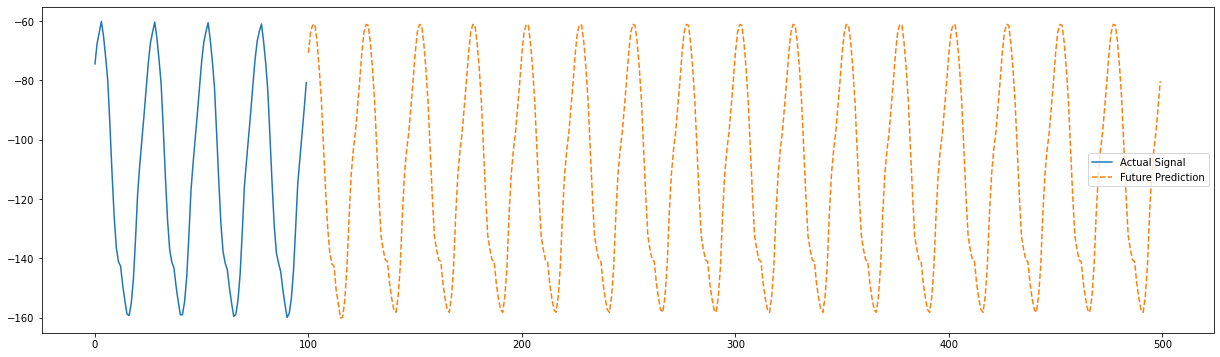

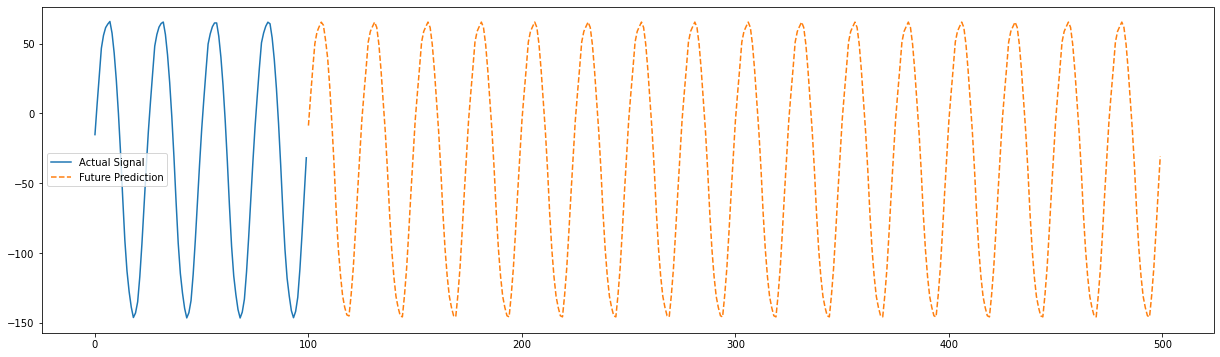

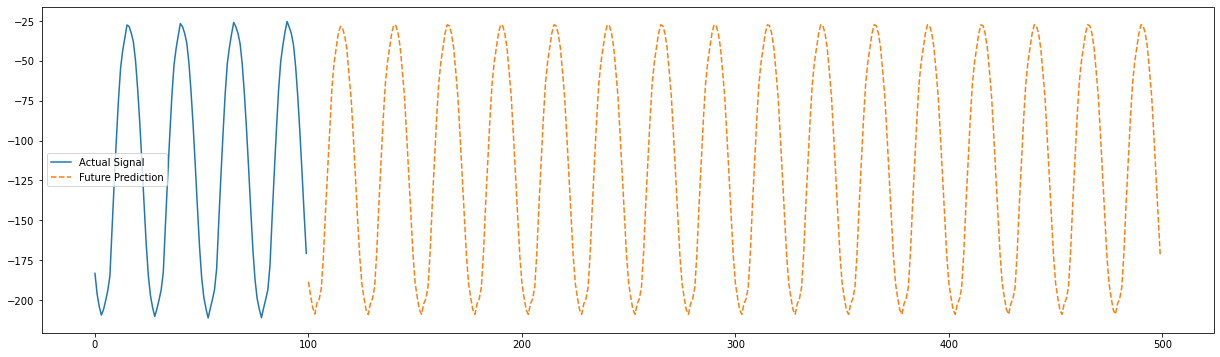

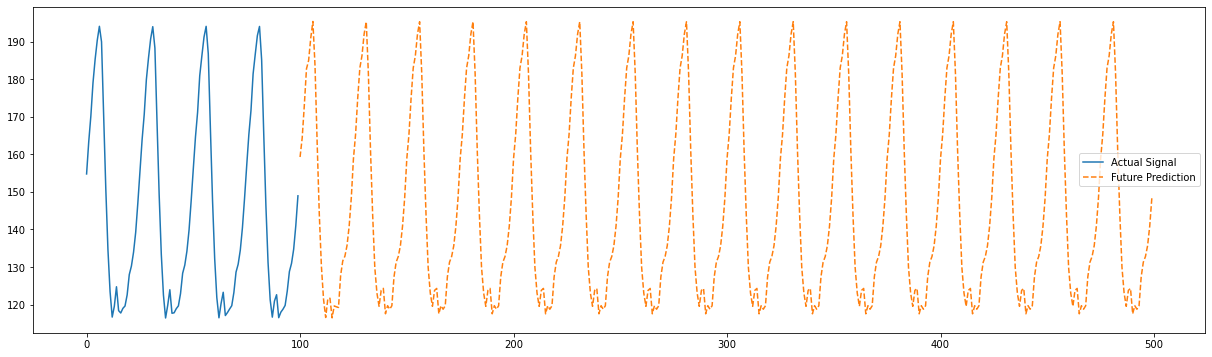

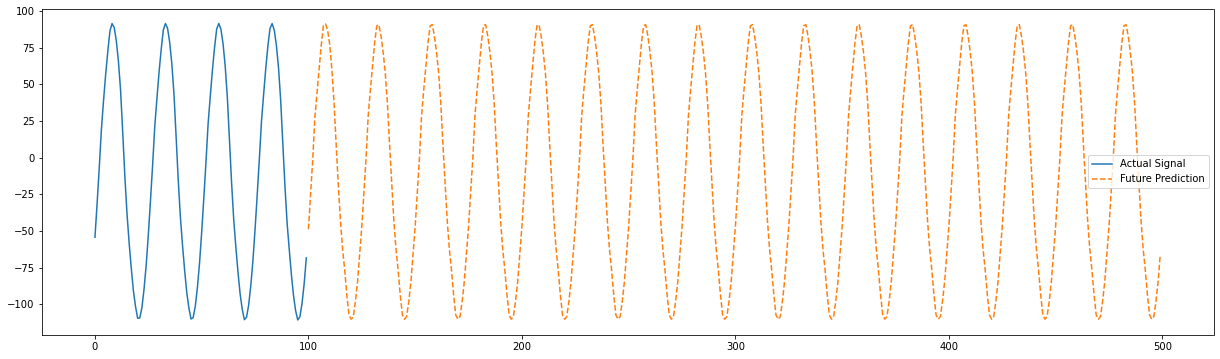

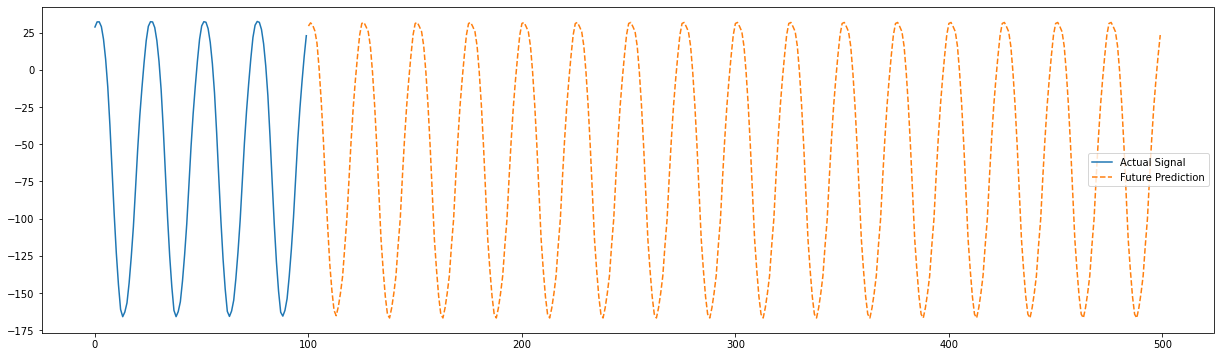

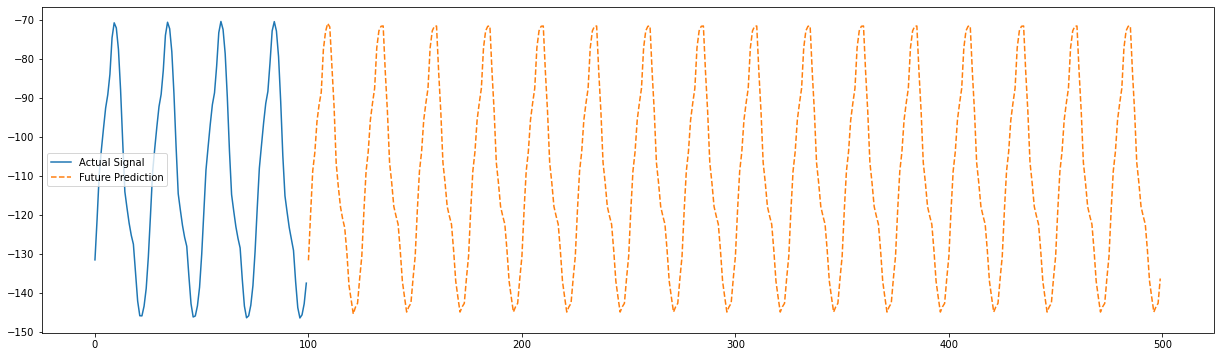

In [8]:
#Train all codes together---LSTM bounch Model
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, TimeDistributed, RepeatVector
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping


units_LSTM=100
# Define the LSTM model
def build_lstm_model(timesteps, latent_dim):

    lstm_model=Sequential()
    lstm_model.add(LSTM(units_LSTM, activation='tanh',input_shape=(timesteps, latent_dim)))
    lstm_model.add(RepeatVector(timesteps))
    lstm_model.add(LSTM(units_LSTM, activation='tanh',return_sequences=True))
    lstm_model.add(TimeDistributed(Dense(latent_dim)))
                     
    return lstm_model

timesteps = 1
latent_dim=encoding_dim
lstm_model = build_lstm_model(timesteps, latent_dim)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
lstm_model.compile(optimizer=optimizer, loss='mse')

#lstm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,clipvalue=1.0), loss='mse')

# Print LSTM model summary
lstm_model.summary()

#Encode the input data
encoded_data=y
print(encoded_data.shape)

# Reshape for LSTM input
encoded_data = np.reshape(encoded_data, (encoded_data.shape[0], timesteps, encoding_dim))
lstm_inputs=encoded_data[:-1]
print("lstm_inputs shape:",lstm_inputs.shape)
lstm_targets=encoded_data[1:]
print("lstm_targets shape:",lstm_inputs.shape)


# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
									factor=0.5,
									patience=10,
									verbose=1,
									mode='min',
									min_delta=1e-10,
									cooldown=0,
									min_lr=0)
# Train the LSTM model
start_time = timeit.default_timer()
lstm_model.fit(lstm_inputs, lstm_targets, epochs=500, batch_size=32,validation_split=0.1,callbacks=[reduce_lr])
print("time spend for training:",timeit.default_timer() - start_time)

lstm_model.save('./Temp_data_Case2/model_bunch_'+str(encoding_dim)+'.h5')

lstm_model = load_model('./Temp_data_Case2/model_bunch_'+str(encoding_dim)+'.h5')

## Reshape for LSTM input
encoded_data = np.reshape(encoded_data, (encoded_data.shape[0], timesteps, latent_dim))

# Predict future states using the LSTM model

predicted_latent = lstm_model.predict(encoded_data[:-1])
print(predicted_latent.shape)

# Decode the predictions to get the original space
decoded_predictions = ae.decoder.predict(np.reshape(predicted_latent, (predicted_latent.shape[0], latent_dim)))

print(decoded_predictions.shape)

# decoded_predictions now contains the future states of your fluid dynamics data
print(two_dimension_data_0[1501,1000:1020])
print(decoded_predictions[1500,1000:1020])

# Extrapolation Function: Predict future timesteps beyond the training sequence
def extrapolate_lstm(lstm_model, encoded_data, future_steps):
    future_latent = []
    current_input = encoded_data
    
    for _ in range(future_steps):
        # Predict the next latent space
        next_latent = lstm_model.predict(current_input)

        future_latent.append(next_latent)
 
        current_input=next_latent
        
    future_latent=np.concatenate(future_latent,axis=1)
    return np.array(future_latent).squeeze()

# Number of future steps to predict
future_steps = 400

#print(encoded_data.shape)

# Perform extrapolation
start_time = timeit.default_timer()
future_latent_predictions = extrapolate_lstm(lstm_model, encoded_data[-1].reshape(1,1,latent_dim),future_steps)
print(encoded_data[-1].shape)
future_latent_predictions=np.array(future_latent_predictions)
print("time spend for prediction:",timeit.default_timer() - start_time)

pickle.dump(future_latent_predictions, open("./Temp_data_Case2/reconstructed_signals_lstm_codes_"+str(encoding_dim)+".pkl", "wb"))

# Decode the future latent predictions to the original space
decoded_future_predictions = [ae.decoder.predict(latent.reshape(1, -1)) for latent in future_latent_predictions]
print(np.array(decoded_future_predictions).shape)

# Combine the original and future predictions for the complete sequence
combined_predictions = np.concatenate([decoded_predictions, np.array(decoded_future_predictions).squeeze()])
print(np.array(decoded_future_predictions).squeeze().shape)
x_lstm=np.array(decoded_future_predictions).squeeze()
pickle.dump(x_lstm, open("./Temp_data_Case2/reconstructed_signals_lstm_bunch_"+str(encoding_dim)+".pkl", "wb"))

# comparison of the difference between origin and predicted
print(x_lstm[70,1000:1020])
print(training_data_whole.shape)
print(training_data_whole.reshape(training_data_whole.shape[0],110536)[1671,1000:1020])

print(x_lstm[300,1000:1020])
print(training_data_whole.reshape(training_data_whole.shape[0],110536)[1901,1000:1020])

print(x_lstm[399,1000:1020])
print(training_data_whole.reshape(training_data_whole.shape[0],110536)[2000,1000:1020])

print(encoded_data.shape)
encoded_data_2=np.transpose(encoded_data.squeeze())
print(encoded_data_2.shape)

future_latent_predictions_2=np.transpose(future_latent_predictions)
print(future_latent_predictions_2.shape)

for idx in range(encoded_data_2.shape[0]):
    plt.figure(figsize=(21, 6))
    plt.plot(encoded_data_2[idx, -100:], label='Actual Signal')
    plt.plot(np.arange(100, 100+ future_steps), future_latent_predictions_2[idx], label='Future Prediction', linestyle='dashed')
    plt.legend()
    plt.show()
    
    

(1601, 7)
(7, 1601)
training_data shape: (1601, 1)
(1531, 70, 1)
(1531, 1)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 70, 100)           40800     
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________
the 0 signal
Epoch 1/500
44/44 [==============================] - 3s 52ms/step - loss: 0.0247 - val_loss: 0.0114
Epoch 2/500
44/44 [==============================] - 2s 42ms/step - loss: 0.0096 - val_loss: 0.0052
Epoch 3/500
44/44 [==============================] - 2s 48ms/step - loss: 0.0025 - val_los

44/44 [==============================] - 2s 44ms/step - loss: 6.4433e-05 - val_loss: 3.6380e-05
Epoch 69/500
44/44 [==============================] - 2s 46ms/step - loss: 6.0756e-05 - val_loss: 3.6944e-05
Epoch 70/500
44/44 [==============================] - 2s 41ms/step - loss: 6.1780e-05 - val_loss: 3.1144e-05
Epoch 71/500
44/44 [==============================] - 2s 40ms/step - loss: 5.9617e-05 - val_loss: 4.7091e-05
Epoch 72/500
44/44 [==============================] - 2s 44ms/step - loss: 7.1250e-05 - val_loss: 5.0803e-05
Epoch 73/500
44/44 [==============================] - 2s 47ms/step - loss: 7.2965e-05 - val_loss: 3.6838e-05
Epoch 74/500
44/44 [==============================] - 2s 48ms/step - loss: 6.3025e-05 - val_loss: 9.1941e-05
Epoch 75/500
44/44 [==============================] - 2s 44ms/step - loss: 8.4491e-05 - val_loss: 2.7771e-05
Epoch 76/500
44/44 [==============================] - 2s 42ms/step - loss: 5.7309e-05 - val_loss: 3.9403e-05
Epoch 77/500
44/44 [============

44/44 [==============================] - 2s 42ms/step - loss: 3.3043e-05 - val_loss: 2.2170e-05
Epoch 212/500
44/44 [==============================] - 2s 45ms/step - loss: 3.2932e-05 - val_loss: 2.2102e-05
Epoch 213/500
44/44 [==============================] - 2s 49ms/step - loss: 3.3067e-05 - val_loss: 2.2122e-05
Epoch 214/500
44/44 [==============================] - 2s 44ms/step - loss: 3.3037e-05 - val_loss: 2.2126e-05
Epoch 215/500
44/44 [==============================] - 2s 50ms/step - loss: 3.3062e-05 - val_loss: 2.2182e-05
Epoch 216/500
44/44 [==============================] - 2s 43ms/step - loss: 3.3361e-05 - val_loss: 2.2739e-05
Epoch 217/500
44/44 [==============================] - 2s 40ms/step - loss: 3.3038e-05 - val_loss: 2.2178e-05
Epoch 218/500
44/44 [==============================] - 2s 48ms/step - loss: 3.2950e-05 - val_loss: 2.2080e-05
Epoch 219/500
44/44 [==============================] - 2s 47ms/step - loss: 3.3231e-05 - val_loss: 2.2182e-05

Epoch 00219: ReduceLROn

Epoch 282/500
44/44 [==============================] - 2s 41ms/step - loss: 3.2679e-05 - val_loss: 2.2037e-05

Epoch 00282: ReduceLROnPlateau reducing learning rate to 6.103515914901436e-08.
Epoch 283/500
44/44 [==============================] - 2s 43ms/step - loss: 3.2676e-05 - val_loss: 2.2038e-05
Epoch 284/500
44/44 [==============================] - 2s 44ms/step - loss: 3.2676e-05 - val_loss: 2.2038e-05
Epoch 285/500
44/44 [==============================] - 2s 46ms/step - loss: 3.2677e-05 - val_loss: 2.2037e-05
Epoch 286/500
44/44 [==============================] - 2s 42ms/step - loss: 3.2678e-05 - val_loss: 2.2038e-05
Epoch 287/500
44/44 [==============================] - 2s 43ms/step - loss: 3.2675e-05 - val_loss: 2.2042e-05
Epoch 288/500
44/44 [==============================] - 2s 44ms/step - loss: 3.2678e-05 - val_loss: 2.2040e-05
Epoch 289/500
44/44 [==============================] - 2s 46ms/step - loss: 3.2676e-05 - val_loss: 2.2039e-05
Epoch 290/500
44/44 [==================

44/44 [==============================] - 2s 43ms/step - loss: 3.2671e-05 - val_loss: 2.2034e-05
Epoch 421/500
44/44 [==============================] - 2s 45ms/step - loss: 3.2671e-05 - val_loss: 2.2034e-05
Epoch 422/500
44/44 [==============================] - 2s 46ms/step - loss: 3.2671e-05 - val_loss: 2.2034e-05

Epoch 00422: ReduceLROnPlateau reducing learning rate to 3.725290475403709e-12.
Epoch 423/500
44/44 [==============================] - 2s 49ms/step - loss: 3.2671e-05 - val_loss: 2.2034e-05
Epoch 424/500
44/44 [==============================] - 2s 44ms/step - loss: 3.2671e-05 - val_loss: 2.2034e-05
Epoch 425/500
44/44 [==============================] - 2s 42ms/step - loss: 3.2671e-05 - val_loss: 2.2034e-05
Epoch 426/500
44/44 [==============================] - 2s 40ms/step - loss: 3.2671e-05 - val_loss: 2.2034e-05
Epoch 427/500
44/44 [==============================] - 2s 47ms/step - loss: 3.2671e-05 - val_loss: 2.2034e-05
Epoch 428/500
44/44 [==============================] 

Epoch 54/500
44/44 [==============================] - 2s 38ms/step - loss: 2.8351e-04 - val_loss: 1.3775e-04
Epoch 55/500
44/44 [==============================] - 2s 40ms/step - loss: 2.6696e-04 - val_loss: 3.0677e-04
Epoch 56/500
44/44 [==============================] - 2s 39ms/step - loss: 4.0564e-04 - val_loss: 7.5869e-05
Epoch 57/500
44/44 [==============================] - 2s 40ms/step - loss: 2.8493e-04 - val_loss: 1.3759e-04
Epoch 58/500
44/44 [==============================] - 2s 44ms/step - loss: 2.6818e-04 - val_loss: 6.6871e-05
Epoch 59/500
44/44 [==============================] - 2s 40ms/step - loss: 2.6165e-04 - val_loss: 6.8208e-05
Epoch 60/500
44/44 [==============================] - 2s 44ms/step - loss: 2.5575e-04 - val_loss: 9.0746e-05
Epoch 61/500
44/44 [==============================] - 2s 39ms/step - loss: 2.6172e-04 - val_loss: 8.0936e-05
Epoch 62/500
44/44 [==============================] - 2s 42ms/step - loss: 2.4067e-04 - val_loss: 5.8472e-05
Epoch 63/500
44/44 

Epoch 196/500
44/44 [==============================] - 2s 40ms/step - loss: 1.3651e-04 - val_loss: 4.8060e-05
Epoch 197/500
44/44 [==============================] - 2s 36ms/step - loss: 1.3645e-04 - val_loss: 4.7950e-05

Epoch 00197: ReduceLROnPlateau reducing learning rate to 1.2207031829802872e-07.
Epoch 198/500
44/44 [==============================] - 2s 40ms/step - loss: 1.3640e-04 - val_loss: 4.7790e-05
Epoch 199/500
44/44 [==============================] - 2s 37ms/step - loss: 1.3636e-04 - val_loss: 4.7799e-05
Epoch 200/500
44/44 [==============================] - 2s 41ms/step - loss: 1.3633e-04 - val_loss: 4.7743e-05
Epoch 201/500
44/44 [==============================] - 2s 40ms/step - loss: 1.3633e-04 - val_loss: 4.7793e-05
Epoch 202/500
44/44 [==============================] - 2s 41ms/step - loss: 1.3634e-04 - val_loss: 4.7713e-05
Epoch 203/500
44/44 [==============================] - 2s 37ms/step - loss: 1.3633e-04 - val_loss: 4.7663e-05
Epoch 204/500
44/44 [=================

44/44 [==============================] - 2s 42ms/step - loss: 1.3626e-04 - val_loss: 4.7789e-05
Epoch 335/500
44/44 [==============================] - 2s 41ms/step - loss: 1.3626e-04 - val_loss: 4.7789e-05
Epoch 336/500
44/44 [==============================] - 2s 43ms/step - loss: 1.3626e-04 - val_loss: 4.7789e-05
Epoch 337/500
44/44 [==============================] - 2s 42ms/step - loss: 1.3626e-04 - val_loss: 4.7789e-05

Epoch 00337: ReduceLROnPlateau reducing learning rate to 7.450580950807417e-12.
Epoch 338/500
44/44 [==============================] - 2s 39ms/step - loss: 1.3626e-04 - val_loss: 4.7789e-05
Epoch 339/500
44/44 [==============================] - 2s 41ms/step - loss: 1.3626e-04 - val_loss: 4.7789e-05
Epoch 340/500
44/44 [==============================] - 2s 43ms/step - loss: 1.3626e-04 - val_loss: 4.7789e-05
Epoch 341/500
44/44 [==============================] - 2s 43ms/step - loss: 1.3626e-04 - val_loss: 4.7789e-05
Epoch 342/500
44/44 [==============================] 

44/44 [==============================] - 2s 41ms/step - loss: 1.3626e-04 - val_loss: 4.7789e-05
Epoch 473/500
44/44 [==============================] - 2s 42ms/step - loss: 1.3626e-04 - val_loss: 4.7789e-05
Epoch 474/500
44/44 [==============================] - 2s 47ms/step - loss: 1.3626e-04 - val_loss: 4.7789e-05
Epoch 475/500
44/44 [==============================] - 2s 39ms/step - loss: 1.3626e-04 - val_loss: 4.7789e-05
Epoch 476/500
44/44 [==============================] - 2s 39ms/step - loss: 1.3626e-04 - val_loss: 4.7789e-05
Epoch 477/500
44/44 [==============================] - 2s 40ms/step - loss: 1.3626e-04 - val_loss: 4.7789e-05

Epoch 00477: ReduceLROnPlateau reducing learning rate to 4.547473724858043e-16.
Epoch 478/500
44/44 [==============================] - 2s 42ms/step - loss: 1.3626e-04 - val_loss: 4.7789e-05
Epoch 479/500
44/44 [==============================] - 2s 37ms/step - loss: 1.3626e-04 - val_loss: 4.7789e-05
Epoch 480/500
44/44 [==============================] 

44/44 [==============================] - 2s 40ms/step - loss: 2.0000e-04 - val_loss: 7.1370e-05
Epoch 110/500
44/44 [==============================] - 2s 44ms/step - loss: 2.0317e-04 - val_loss: 6.9869e-05
Epoch 111/500
44/44 [==============================] - 2s 40ms/step - loss: 2.0488e-04 - val_loss: 8.0715e-05

Epoch 00111: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Epoch 112/500
44/44 [==============================] - 2s 39ms/step - loss: 1.9757e-04 - val_loss: 7.4794e-05
Epoch 113/500
44/44 [==============================] - 2s 42ms/step - loss: 1.9361e-04 - val_loss: 7.1382e-05
Epoch 114/500
44/44 [==============================] - 2s 40ms/step - loss: 2.0582e-04 - val_loss: 7.1077e-05
Epoch 115/500
44/44 [==============================] - 2s 44ms/step - loss: 1.9476e-04 - val_loss: 7.3463e-05
Epoch 116/500
44/44 [==============================] - 2s 41ms/step - loss: 1.9265e-04 - val_loss: 7.4508e-05
Epoch 117/500
44/44 [==============================] 

44/44 [==============================] - 2s 39ms/step - loss: 1.7141e-04 - val_loss: 6.5075e-05
Epoch 183/500
44/44 [==============================] - 2s 37ms/step - loss: 1.7295e-04 - val_loss: 6.1606e-05
Epoch 184/500
44/44 [==============================] - 2s 40ms/step - loss: 1.6911e-04 - val_loss: 6.4154e-05
Epoch 185/500
44/44 [==============================] - 2s 40ms/step - loss: 1.8646e-04 - val_loss: 5.7741e-05
Epoch 186/500
44/44 [==============================] - 2s 37ms/step - loss: 1.6815e-04 - val_loss: 5.7322e-05
Epoch 187/500
44/44 [==============================] - 2s 37ms/step - loss: 1.6923e-04 - val_loss: 6.1720e-05
Epoch 188/500
44/44 [==============================] - 2s 40ms/step - loss: 1.7432e-04 - val_loss: 5.8240e-05
Epoch 189/500
44/44 [==============================] - 2s 40ms/step - loss: 1.6873e-04 - val_loss: 5.9996e-05
Epoch 190/500
44/44 [==============================] - 2s 40ms/step - loss: 1.6889e-04 - val_loss: 6.0413e-05
Epoch 191/500
44/44 [===

44/44 [==============================] - 2s 38ms/step - loss: 1.3361e-04 - val_loss: 4.3706e-05
Epoch 330/500
44/44 [==============================] - 2s 44ms/step - loss: 1.3346e-04 - val_loss: 4.3659e-05
Epoch 331/500
44/44 [==============================] - 2s 40ms/step - loss: 1.3356e-04 - val_loss: 4.3788e-05
Epoch 332/500
44/44 [==============================] - 2s 46ms/step - loss: 1.3326e-04 - val_loss: 4.3572e-05
Epoch 333/500
44/44 [==============================] - 2s 42ms/step - loss: 1.3321e-04 - val_loss: 4.4563e-05
Epoch 334/500
44/44 [==============================] - 2s 42ms/step - loss: 1.3356e-04 - val_loss: 4.3597e-05
Epoch 335/500
44/44 [==============================] - 2s 47ms/step - loss: 1.3328e-04 - val_loss: 4.3727e-05
Epoch 336/500
44/44 [==============================] - 2s 42ms/step - loss: 1.3406e-04 - val_loss: 4.4620e-05
Epoch 337/500
44/44 [==============================] - 2s 39ms/step - loss: 1.3317e-04 - val_loss: 4.4237e-05

Epoch 00337: ReduceLROn

Epoch 400/500
44/44 [==============================] - 2s 43ms/step - loss: 1.3156e-04 - val_loss: 4.3140e-05
Epoch 401/500
44/44 [==============================] - 2s 48ms/step - loss: 1.3160e-04 - val_loss: 4.3180e-05
Epoch 402/500
44/44 [==============================] - 2s 45ms/step - loss: 1.3155e-04 - val_loss: 4.3188e-05
Epoch 403/500
44/44 [==============================] - 2s 43ms/step - loss: 1.3154e-04 - val_loss: 4.3238e-05
Epoch 404/500
44/44 [==============================] - 2s 42ms/step - loss: 1.3158e-04 - val_loss: 4.3231e-05
Epoch 405/500
44/44 [==============================] - 2s 41ms/step - loss: 1.3155e-04 - val_loss: 4.3236e-05
Epoch 406/500
44/44 [==============================] - 2s 37ms/step - loss: 1.3155e-04 - val_loss: 4.3209e-05
Epoch 407/500
44/44 [==============================] - 2s 41ms/step - loss: 1.3152e-04 - val_loss: 4.3155e-05

Epoch 00407: ReduceLROnPlateau reducing learning rate to 6.103515914901436e-08.
Epoch 408/500
44/44 [==================

44/44 [==============================] - 2s 40ms/step - loss: 2.9330e-04 - val_loss: 1.5102e-04
Epoch 35/500
44/44 [==============================] - 2s 38ms/step - loss: 2.7066e-04 - val_loss: 1.3187e-04
Epoch 36/500
44/44 [==============================] - 2s 39ms/step - loss: 2.6326e-04 - val_loss: 1.0889e-04
Epoch 37/500
44/44 [==============================] - 2s 40ms/step - loss: 3.5500e-04 - val_loss: 6.0401e-05
Epoch 38/500
44/44 [==============================] - 2s 38ms/step - loss: 2.7591e-04 - val_loss: 9.3287e-05
Epoch 39/500
44/44 [==============================] - 2s 38ms/step - loss: 2.4414e-04 - val_loss: 8.4486e-05
Epoch 40/500
44/44 [==============================] - 2s 36ms/step - loss: 2.2625e-04 - val_loss: 1.6252e-04
Epoch 41/500
44/44 [==============================] - 2s 35ms/step - loss: 2.1778e-04 - val_loss: 1.1618e-04
Epoch 42/500
44/44 [==============================] - 1s 33ms/step - loss: 2.1642e-04 - val_loss: 4.7684e-04
Epoch 43/500
44/44 [============

Epoch 107/500
44/44 [==============================] - 2s 36ms/step - loss: 8.3944e-05 - val_loss: 5.4117e-05
Epoch 108/500
44/44 [==============================] - 2s 35ms/step - loss: 8.4334e-05 - val_loss: 4.9734e-05
Epoch 109/500
44/44 [==============================] - 2s 41ms/step - loss: 8.2179e-05 - val_loss: 5.0309e-05
Epoch 110/500
44/44 [==============================] - 2s 41ms/step - loss: 8.2432e-05 - val_loss: 6.5587e-05
Epoch 111/500
44/44 [==============================] - 2s 41ms/step - loss: 8.7798e-05 - val_loss: 8.5149e-05
Epoch 112/500
44/44 [==============================] - 2s 43ms/step - loss: 8.3572e-05 - val_loss: 5.9386e-05
Epoch 113/500
44/44 [==============================] - 2s 45ms/step - loss: 8.0320e-05 - val_loss: 5.0601e-05
Epoch 114/500
44/44 [==============================] - 2s 36ms/step - loss: 8.1486e-05 - val_loss: 7.9790e-05
Epoch 115/500
44/44 [==============================] - 2s 41ms/step - loss: 8.0073e-05 - val_loss: 5.6472e-05
Epoch 116/

44/44 [==============================] - 2s 39ms/step - loss: 7.6648e-05 - val_loss: 4.2825e-05
Epoch 181/500
44/44 [==============================] - 2s 41ms/step - loss: 6.4142e-05 - val_loss: 4.6875e-05
Epoch 182/500
44/44 [==============================] - 2s 43ms/step - loss: 6.6235e-05 - val_loss: 4.2069e-05
Epoch 183/500
44/44 [==============================] - 2s 43ms/step - loss: 6.4012e-05 - val_loss: 4.2311e-05
Epoch 184/500
44/44 [==============================] - 2s 41ms/step - loss: 6.7970e-05 - val_loss: 4.2442e-05
Epoch 185/500
44/44 [==============================] - 2s 41ms/step - loss: 6.8177e-05 - val_loss: 4.3406e-05
Epoch 186/500
44/44 [==============================] - 2s 39ms/step - loss: 6.3201e-05 - val_loss: 4.3984e-05
Epoch 187/500
44/44 [==============================] - 2s 38ms/step - loss: 6.2752e-05 - val_loss: 4.4617e-05
Epoch 188/500
44/44 [==============================] - 2s 40ms/step - loss: 6.3357e-05 - val_loss: 4.4026e-05
Epoch 189/500
44/44 [===

44/44 [==============================] - 2s 40ms/step - loss: 5.7471e-05 - val_loss: 4.0417e-05
Epoch 254/500
44/44 [==============================] - 2s 40ms/step - loss: 5.8756e-05 - val_loss: 3.9797e-05
Epoch 255/500
44/44 [==============================] - 2s 37ms/step - loss: 5.6946e-05 - val_loss: 3.8599e-05
Epoch 256/500
44/44 [==============================] - 2s 38ms/step - loss: 5.7494e-05 - val_loss: 3.9080e-05
Epoch 257/500
44/44 [==============================] - 2s 41ms/step - loss: 5.7270e-05 - val_loss: 3.8605e-05
Epoch 258/500
44/44 [==============================] - 2s 41ms/step - loss: 5.7182e-05 - val_loss: 3.8608e-05
Epoch 259/500
44/44 [==============================] - 2s 41ms/step - loss: 5.8001e-05 - val_loss: 4.2613e-05
Epoch 260/500
44/44 [==============================] - 2s 40ms/step - loss: 6.1260e-05 - val_loss: 3.9024e-05
Epoch 261/500
44/44 [==============================] - 2s 41ms/step - loss: 5.7582e-05 - val_loss: 3.9395e-05
Epoch 262/500
44/44 [===

44/44 [==============================] - 2s 44ms/step - loss: 5.4757e-05 - val_loss: 3.7498e-05
Epoch 395/500
44/44 [==============================] - 2s 44ms/step - loss: 5.4757e-05 - val_loss: 3.7497e-05
Epoch 396/500
44/44 [==============================] - 2s 40ms/step - loss: 5.4756e-05 - val_loss: 3.7498e-05
Epoch 397/500
44/44 [==============================] - 2s 43ms/step - loss: 5.4756e-05 - val_loss: 3.7498e-05
Epoch 398/500
44/44 [==============================] - 2s 38ms/step - loss: 5.4756e-05 - val_loss: 3.7497e-05
Epoch 399/500
44/44 [==============================] - 2s 43ms/step - loss: 5.4756e-05 - val_loss: 3.7496e-05

Epoch 00399: ReduceLROnPlateau reducing learning rate to 3.814697446813398e-09.
Epoch 400/500
44/44 [==============================] - 2s 38ms/step - loss: 5.4756e-05 - val_loss: 3.7496e-05
Epoch 401/500
44/44 [==============================] - 2s 39ms/step - loss: 5.4756e-05 - val_loss: 3.7498e-05
Epoch 402/500
44/44 [==============================] 

Epoch 27/500
44/44 [==============================] - 2s 42ms/step - loss: 4.6126e-04 - val_loss: 2.1363e-04

Epoch 00027: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 28/500
44/44 [==============================] - 2s 43ms/step - loss: 4.4688e-04 - val_loss: 2.3429e-04
Epoch 29/500
44/44 [==============================] - 2s 41ms/step - loss: 4.6666e-04 - val_loss: 3.7347e-04
Epoch 30/500
44/44 [==============================] - 2s 40ms/step - loss: 4.3319e-04 - val_loss: 2.0173e-04
Epoch 31/500
44/44 [==============================] - 2s 37ms/step - loss: 4.0514e-04 - val_loss: 2.7333e-04
Epoch 32/500
44/44 [==============================] - 2s 40ms/step - loss: 4.2626e-04 - val_loss: 2.9500e-04
Epoch 33/500
44/44 [==============================] - 2s 38ms/step - loss: 5.1178e-04 - val_loss: 2.7295e-04
Epoch 34/500
44/44 [==============================] - 2s 38ms/step - loss: 4.2267e-04 - val_loss: 1.7216e-04
Epoch 35/500
44/44 [===========================

Epoch 100/500
44/44 [==============================] - 2s 39ms/step - loss: 1.8915e-04 - val_loss: 8.7536e-05
Epoch 101/500
44/44 [==============================] - 2s 34ms/step - loss: 1.7717e-04 - val_loss: 8.1315e-05
Epoch 102/500
44/44 [==============================] - 2s 34ms/step - loss: 1.7705e-04 - val_loss: 1.9129e-04
Epoch 103/500
44/44 [==============================] - 2s 41ms/step - loss: 1.9574e-04 - val_loss: 8.8225e-05
Epoch 104/500
44/44 [==============================] - 2s 39ms/step - loss: 1.7669e-04 - val_loss: 1.4669e-04
Epoch 105/500
44/44 [==============================] - 2s 40ms/step - loss: 1.7813e-04 - val_loss: 7.9606e-05
Epoch 106/500
44/44 [==============================] - 2s 42ms/step - loss: 1.6897e-04 - val_loss: 1.0558e-04
Epoch 107/500
44/44 [==============================] - 2s 39ms/step - loss: 1.8085e-04 - val_loss: 1.2555e-04

Epoch 00107: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 108/500
44/44 [===================

44/44 [==============================] - 2s 44ms/step - loss: 1.4373e-04 - val_loss: 7.9496e-05
Epoch 239/500
44/44 [==============================] - 2s 42ms/step - loss: 1.4373e-04 - val_loss: 7.9497e-05
Epoch 240/500
44/44 [==============================] - 2s 39ms/step - loss: 1.4372e-04 - val_loss: 7.9495e-05
Epoch 241/500
44/44 [==============================] - 2s 40ms/step - loss: 1.4372e-04 - val_loss: 7.9497e-05
Epoch 242/500
44/44 [==============================] - 2s 42ms/step - loss: 1.4373e-04 - val_loss: 7.9497e-05
Epoch 243/500
44/44 [==============================] - 2s 43ms/step - loss: 1.4373e-04 - val_loss: 7.9494e-05
Epoch 244/500
44/44 [==============================] - 2s 46ms/step - loss: 1.4372e-04 - val_loss: 7.9496e-05
Epoch 245/500
44/44 [==============================] - 2s 44ms/step - loss: 1.4373e-04 - val_loss: 7.9490e-05
Epoch 246/500
44/44 [==============================] - 2s 44ms/step - loss: 1.4373e-04 - val_loss: 7.9490e-05
Epoch 247/500
44/44 [===

44/44 [==============================] - 2s 42ms/step - loss: 1.4372e-04 - val_loss: 7.9492e-05
Epoch 309/500
44/44 [==============================] - 2s 39ms/step - loss: 1.4372e-04 - val_loss: 7.9492e-05
Epoch 310/500
44/44 [==============================] - 2s 39ms/step - loss: 1.4372e-04 - val_loss: 7.9492e-05
Epoch 311/500
44/44 [==============================] - 2s 40ms/step - loss: 1.4372e-04 - val_loss: 7.9492e-05
Epoch 312/500
44/44 [==============================] - 2s 36ms/step - loss: 1.4372e-04 - val_loss: 7.9492e-05
Epoch 313/500
44/44 [==============================] - 2s 40ms/step - loss: 1.4372e-04 - val_loss: 7.9492e-05
Epoch 314/500
44/44 [==============================] - 2s 35ms/step - loss: 1.4372e-04 - val_loss: 7.9492e-05
Epoch 315/500
44/44 [==============================] - 2s 41ms/step - loss: 1.4372e-04 - val_loss: 7.9491e-05
Epoch 316/500
44/44 [==============================] - 2s 39ms/step - loss: 1.4372e-04 - val_loss: 7.9492e-05
Epoch 317/500
44/44 [===

44/44 [==============================] - 2s 38ms/step - loss: 1.4372e-04 - val_loss: 7.9492e-05
Epoch 379/500
44/44 [==============================] - 2s 42ms/step - loss: 1.4372e-04 - val_loss: 7.9492e-05
Epoch 380/500
44/44 [==============================] - 2s 39ms/step - loss: 1.4372e-04 - val_loss: 7.9492e-05
Epoch 381/500
44/44 [==============================] - 2s 42ms/step - loss: 1.4372e-04 - val_loss: 7.9492e-05
Epoch 382/500
44/44 [==============================] - 2s 40ms/step - loss: 1.4372e-04 - val_loss: 7.9492e-05
Epoch 383/500
44/44 [==============================] - 2s 35ms/step - loss: 1.4372e-04 - val_loss: 7.9492e-05
Epoch 384/500
44/44 [==============================] - 2s 39ms/step - loss: 1.4372e-04 - val_loss: 7.9492e-05
Epoch 385/500
44/44 [==============================] - 2s 40ms/step - loss: 1.4372e-04 - val_loss: 7.9492e-05
Epoch 386/500
44/44 [==============================] - 2s 43ms/step - loss: 1.4372e-04 - val_loss: 7.9492e-05
Epoch 387/500
44/44 [===

44/44 [==============================] - 2s 43ms/step - loss: 1.4372e-04 - val_loss: 7.9492e-05
Epoch 449/500
44/44 [==============================] - 2s 42ms/step - loss: 1.4372e-04 - val_loss: 7.9492e-05
Epoch 450/500
44/44 [==============================] - 2s 40ms/step - loss: 1.4372e-04 - val_loss: 7.9492e-05
Epoch 451/500
44/44 [==============================] - 2s 40ms/step - loss: 1.4372e-04 - val_loss: 7.9492e-05
Epoch 452/500
44/44 [==============================] - 2s 44ms/step - loss: 1.4372e-04 - val_loss: 7.9492e-05
Epoch 453/500
44/44 [==============================] - 2s 43ms/step - loss: 1.4372e-04 - val_loss: 7.9492e-05
Epoch 454/500
44/44 [==============================] - 2s 40ms/step - loss: 1.4372e-04 - val_loss: 7.9492e-05
Epoch 455/500
44/44 [==============================] - 2s 41ms/step - loss: 1.4372e-04 - val_loss: 7.9492e-05
Epoch 456/500
44/44 [==============================] - 2s 46ms/step - loss: 1.4372e-04 - val_loss: 7.9492e-05
Epoch 457/500
44/44 [===

44/44 [==============================] - 2s 39ms/step - loss: 6.6095e-04 - val_loss: 4.6785e-04
Epoch 12/500
44/44 [==============================] - 2s 38ms/step - loss: 6.7516e-04 - val_loss: 0.0012
Epoch 13/500
44/44 [==============================] - 2s 43ms/step - loss: 8.2943e-04 - val_loss: 2.6982e-04
Epoch 14/500
44/44 [==============================] - 2s 41ms/step - loss: 5.5641e-04 - val_loss: 2.3790e-04

Epoch 00014: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 15/500
44/44 [==============================] - 2s 41ms/step - loss: 5.3582e-04 - val_loss: 1.6884e-04
Epoch 16/500
44/44 [==============================] - 2s 44ms/step - loss: 5.3432e-04 - val_loss: 2.5306e-04
Epoch 17/500
44/44 [==============================] - 2s 42ms/step - loss: 5.8575e-04 - val_loss: 2.2786e-04
Epoch 18/500
44/44 [==============================] - 2s 44ms/step - loss: 4.8479e-04 - val_loss: 8.1996e-05
Epoch 19/500
44/44 [==============================] - 2s 39ms/st

Epoch 85/500
44/44 [==============================] - 2s 39ms/step - loss: 1.2802e-04 - val_loss: 1.7641e-04

Epoch 00085: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 86/500
44/44 [==============================] - 2s 40ms/step - loss: 1.2276e-04 - val_loss: 3.0831e-05
Epoch 87/500
44/44 [==============================] - 2s 39ms/step - loss: 1.0643e-04 - val_loss: 4.4010e-05
Epoch 88/500
44/44 [==============================] - 2s 42ms/step - loss: 1.0916e-04 - val_loss: 3.3572e-05
Epoch 89/500
44/44 [==============================] - 2s 42ms/step - loss: 1.1077e-04 - val_loss: 3.1639e-05
Epoch 90/500
44/44 [==============================] - 2s 43ms/step - loss: 1.1124e-04 - val_loss: 2.2574e-04
Epoch 91/500
44/44 [==============================] - 2s 43ms/step - loss: 1.7391e-04 - val_loss: 3.4332e-05
Epoch 92/500
44/44 [==============================] - 2s 41ms/step - loss: 1.0988e-04 - val_loss: 2.6167e-05
Epoch 93/500
44/44 [===========================

44/44 [==============================] - 2s 40ms/step - loss: 8.1353e-05 - val_loss: 2.7023e-05
Epoch 224/500
44/44 [==============================] - 2s 41ms/step - loss: 8.1357e-05 - val_loss: 2.7027e-05
Epoch 225/500
44/44 [==============================] - 2s 43ms/step - loss: 8.1357e-05 - val_loss: 2.7021e-05
Epoch 226/500
44/44 [==============================] - 2s 41ms/step - loss: 8.1358e-05 - val_loss: 2.7015e-05
Epoch 227/500
44/44 [==============================] - 2s 36ms/step - loss: 8.1357e-05 - val_loss: 2.7019e-05
Epoch 228/500
44/44 [==============================] - 2s 44ms/step - loss: 8.1356e-05 - val_loss: 2.7023e-05
Epoch 229/500
44/44 [==============================] - 2s 38ms/step - loss: 8.1357e-05 - val_loss: 2.7023e-05
Epoch 230/500
44/44 [==============================] - 2s 39ms/step - loss: 8.1357e-05 - val_loss: 2.7016e-05
Epoch 231/500
44/44 [==============================] - 2s 41ms/step - loss: 8.1356e-05 - val_loss: 2.7010e-05
Epoch 232/500
44/44 [===

44/44 [==============================] - 2s 44ms/step - loss: 8.1352e-05 - val_loss: 2.7040e-05
Epoch 294/500
44/44 [==============================] - 2s 42ms/step - loss: 8.1352e-05 - val_loss: 2.7040e-05
Epoch 295/500
44/44 [==============================] - 2s 44ms/step - loss: 8.1352e-05 - val_loss: 2.7040e-05
Epoch 296/500
44/44 [==============================] - 2s 40ms/step - loss: 8.1352e-05 - val_loss: 2.7040e-05
Epoch 297/500
44/44 [==============================] - 2s 44ms/step - loss: 8.1352e-05 - val_loss: 2.7040e-05
Epoch 298/500
44/44 [==============================] - 2s 43ms/step - loss: 8.1352e-05 - val_loss: 2.7040e-05
Epoch 299/500
44/44 [==============================] - 2s 42ms/step - loss: 8.1352e-05 - val_loss: 2.7040e-05
Epoch 300/500
44/44 [==============================] - 2s 41ms/step - loss: 8.1352e-05 - val_loss: 2.7040e-05
Epoch 301/500
44/44 [==============================] - 2s 39ms/step - loss: 8.1352e-05 - val_loss: 2.7040e-05
Epoch 302/500
44/44 [===

44/44 [==============================] - 2s 39ms/step - loss: 8.1352e-05 - val_loss: 2.7040e-05
Epoch 364/500
44/44 [==============================] - 1s 33ms/step - loss: 8.1352e-05 - val_loss: 2.7040e-05
Epoch 365/500
44/44 [==============================] - 2s 35ms/step - loss: 8.1352e-05 - val_loss: 2.7040e-05
Epoch 366/500
44/44 [==============================] - 2s 39ms/step - loss: 8.1352e-05 - val_loss: 2.7040e-05
Epoch 367/500
44/44 [==============================] - 2s 37ms/step - loss: 8.1352e-05 - val_loss: 2.7040e-05
Epoch 368/500
44/44 [==============================] - 2s 41ms/step - loss: 8.1352e-05 - val_loss: 2.7040e-05
Epoch 369/500
44/44 [==============================] - 2s 43ms/step - loss: 8.1352e-05 - val_loss: 2.7040e-05
Epoch 370/500
44/44 [==============================] - 2s 38ms/step - loss: 8.1352e-05 - val_loss: 2.7040e-05
Epoch 371/500
44/44 [==============================] - 2s 35ms/step - loss: 8.1352e-05 - val_loss: 2.7040e-05
Epoch 372/500
44/44 [===

44/44 [==============================] - 2s 39ms/step - loss: 8.1352e-05 - val_loss: 2.7040e-05
Epoch 434/500
44/44 [==============================] - 2s 38ms/step - loss: 8.1352e-05 - val_loss: 2.7040e-05
Epoch 435/500
44/44 [==============================] - 2s 41ms/step - loss: 8.1352e-05 - val_loss: 2.7040e-05
Epoch 436/500
44/44 [==============================] - 2s 41ms/step - loss: 8.1352e-05 - val_loss: 2.7040e-05
Epoch 437/500
44/44 [==============================] - 2s 40ms/step - loss: 8.1352e-05 - val_loss: 2.7040e-05
Epoch 438/500
44/44 [==============================] - 2s 47ms/step - loss: 8.1352e-05 - val_loss: 2.7040e-05
Epoch 439/500
44/44 [==============================] - 2s 44ms/step - loss: 8.1352e-05 - val_loss: 2.7040e-05
Epoch 440/500
44/44 [==============================] - 2s 41ms/step - loss: 8.1352e-05 - val_loss: 2.7040e-05
Epoch 441/500
44/44 [==============================] - 2s 43ms/step - loss: 8.1352e-05 - val_loss: 2.7040e-05
Epoch 442/500
44/44 [===

Epoch 1/500
44/44 [==============================] - 3s 46ms/step - loss: 0.0510 - val_loss: 0.0243
Epoch 2/500
44/44 [==============================] - 2s 45ms/step - loss: 0.0190 - val_loss: 0.0188
Epoch 3/500
44/44 [==============================] - 2s 41ms/step - loss: 0.0116 - val_loss: 0.0025
Epoch 4/500
44/44 [==============================] - 2s 44ms/step - loss: 0.0046 - val_loss: 0.0015
Epoch 5/500
44/44 [==============================] - 2s 40ms/step - loss: 0.0027 - val_loss: 0.0014
Epoch 6/500
44/44 [==============================] - 2s 43ms/step - loss: 0.0024 - val_loss: 0.0015
Epoch 7/500
44/44 [==============================] - 2s 41ms/step - loss: 0.0025 - val_loss: 0.0013
Epoch 8/500
44/44 [==============================] - 2s 41ms/step - loss: 0.0026 - val_loss: 0.0015
Epoch 9/500
44/44 [==============================] - 2s 39ms/step - loss: 0.0024 - val_loss: 0.0015
Epoch 10/500
44/44 [==============================] - 2s 38ms/step - loss: 0.0025 - val_loss: 0.0012

44/44 [==============================] - 2s 38ms/step - loss: 1.4551e-04 - val_loss: 5.9576e-05
Epoch 146/500
44/44 [==============================] - 2s 40ms/step - loss: 1.4548e-04 - val_loss: 5.9524e-05
Epoch 147/500
44/44 [==============================] - 2s 38ms/step - loss: 1.4563e-04 - val_loss: 5.9566e-05
Epoch 148/500
44/44 [==============================] - 2s 42ms/step - loss: 1.4574e-04 - val_loss: 5.9754e-05
Epoch 149/500
44/44 [==============================] - 2s 39ms/step - loss: 1.4572e-04 - val_loss: 5.9636e-05

Epoch 00149: ReduceLROnPlateau reducing learning rate to 4.882812731921149e-07.
Epoch 150/500
44/44 [==============================] - 2s 36ms/step - loss: 1.4589e-04 - val_loss: 6.0085e-05
Epoch 151/500
44/44 [==============================] - 2s 42ms/step - loss: 1.4537e-04 - val_loss: 5.9844e-05
Epoch 152/500
44/44 [==============================] - 2s 39ms/step - loss: 1.4534e-04 - val_loss: 5.9856e-05
Epoch 153/500
44/44 [==============================] 

44/44 [==============================] - 2s 40ms/step - loss: 1.4485e-04 - val_loss: 5.9716e-05
Epoch 284/500
44/44 [==============================] - 2s 41ms/step - loss: 1.4485e-04 - val_loss: 5.9716e-05
Epoch 285/500
44/44 [==============================] - 2s 41ms/step - loss: 1.4485e-04 - val_loss: 5.9716e-05
Epoch 286/500
44/44 [==============================] - 2s 43ms/step - loss: 1.4485e-04 - val_loss: 5.9716e-05
Epoch 287/500
44/44 [==============================] - 2s 43ms/step - loss: 1.4485e-04 - val_loss: 5.9716e-05
Epoch 288/500
44/44 [==============================] - 2s 39ms/step - loss: 1.4485e-04 - val_loss: 5.9716e-05
Epoch 289/500
44/44 [==============================] - 2s 41ms/step - loss: 1.4485e-04 - val_loss: 5.9716e-05

Epoch 00289: ReduceLROnPlateau reducing learning rate to 2.980232380322967e-11.
Epoch 290/500
44/44 [==============================] - 2s 43ms/step - loss: 1.4485e-04 - val_loss: 5.9716e-05
Epoch 291/500
44/44 [==============================] 

44/44 [==============================] - 2s 38ms/step - loss: 1.4485e-04 - val_loss: 5.9716e-05
Epoch 422/500
44/44 [==============================] - 2s 39ms/step - loss: 1.4485e-04 - val_loss: 5.9716e-05
Epoch 423/500
44/44 [==============================] - 2s 42ms/step - loss: 1.4485e-04 - val_loss: 5.9716e-05
Epoch 424/500
44/44 [==============================] - 2s 36ms/step - loss: 1.4485e-04 - val_loss: 5.9716e-05
Epoch 425/500
44/44 [==============================] - 2s 39ms/step - loss: 1.4485e-04 - val_loss: 5.9716e-05
Epoch 426/500
44/44 [==============================] - 2s 40ms/step - loss: 1.4485e-04 - val_loss: 5.9716e-05
Epoch 427/500
44/44 [==============================] - 2s 35ms/step - loss: 1.4485e-04 - val_loss: 5.9716e-05
Epoch 428/500
44/44 [==============================] - 2s 40ms/step - loss: 1.4485e-04 - val_loss: 5.9716e-05
Epoch 429/500
44/44 [==============================] - 2s 39ms/step - loss: 1.4485e-04 - val_loss: 5.9716e-05

Epoch 00429: ReduceLROn

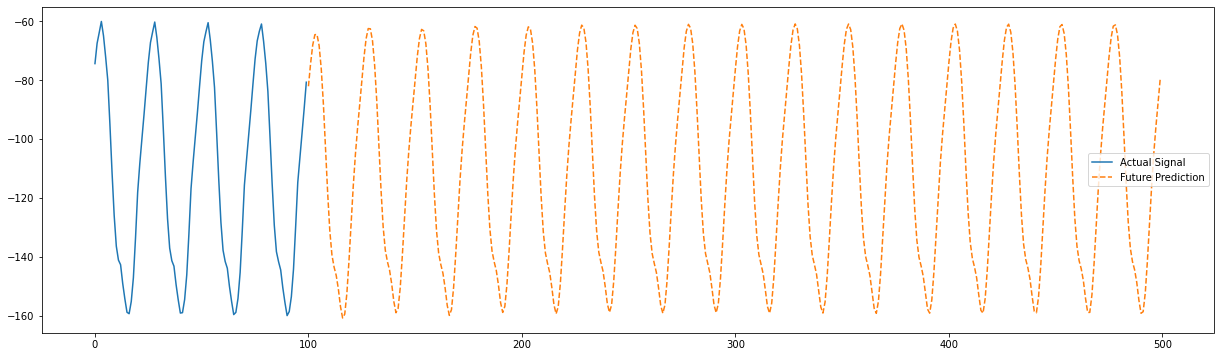

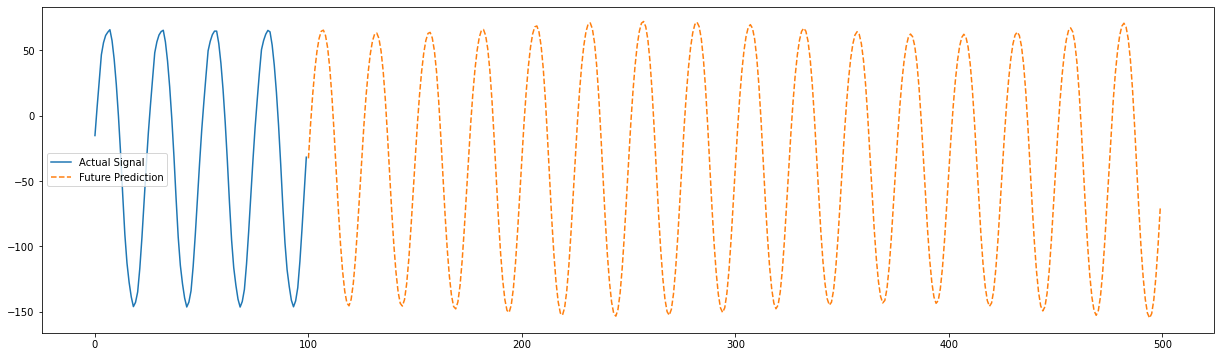

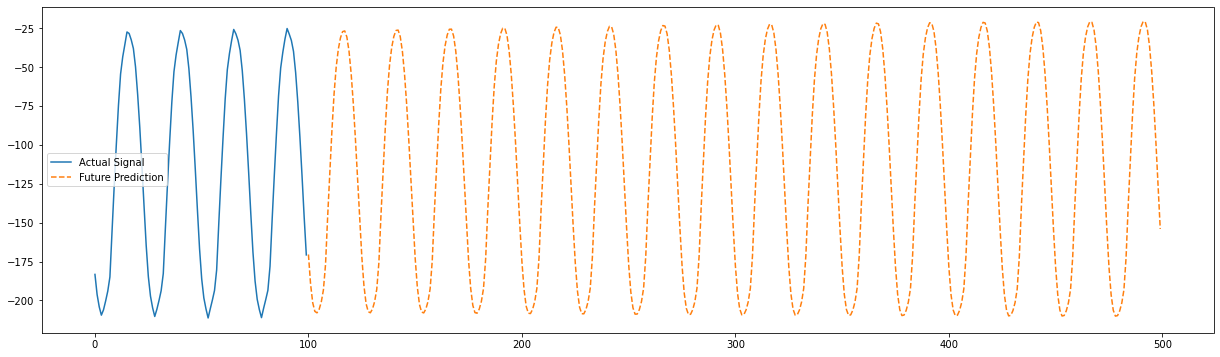

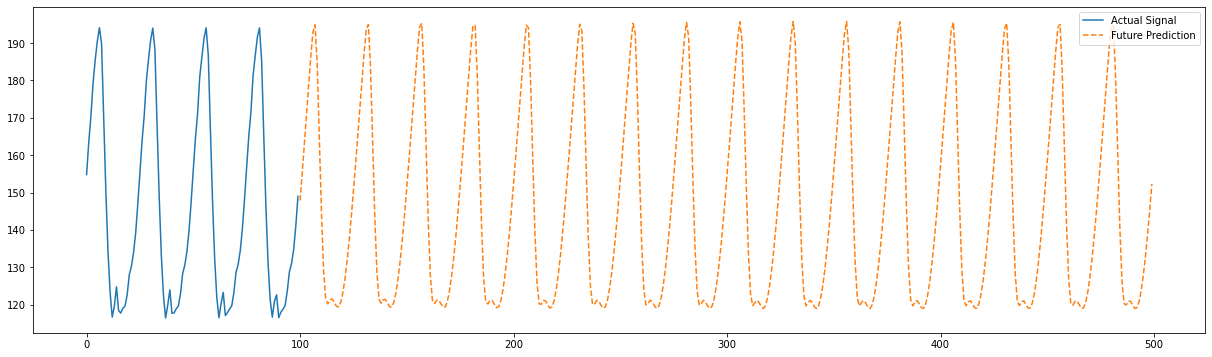

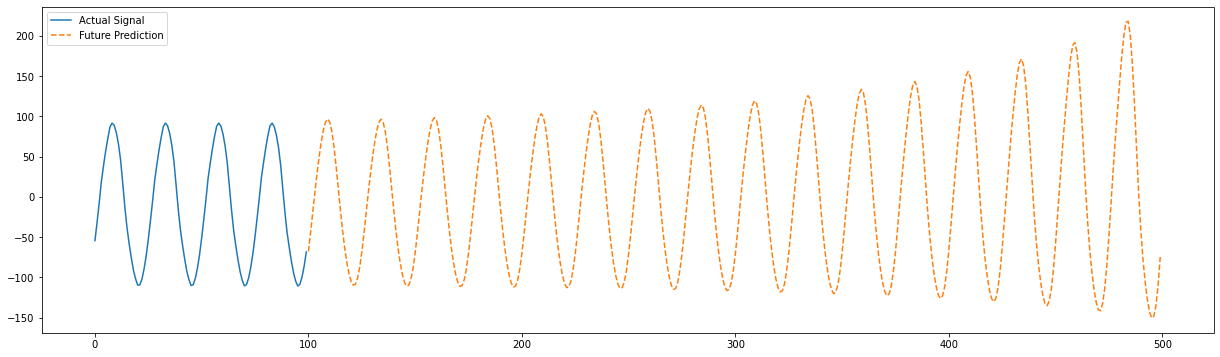

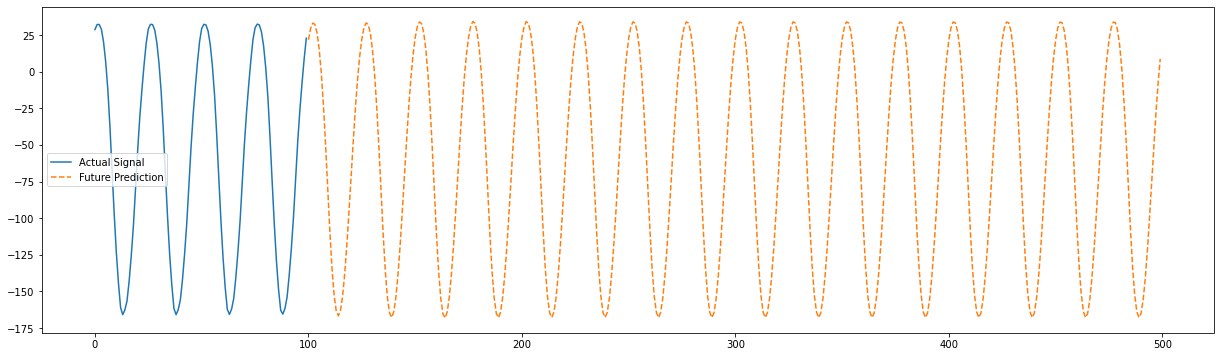

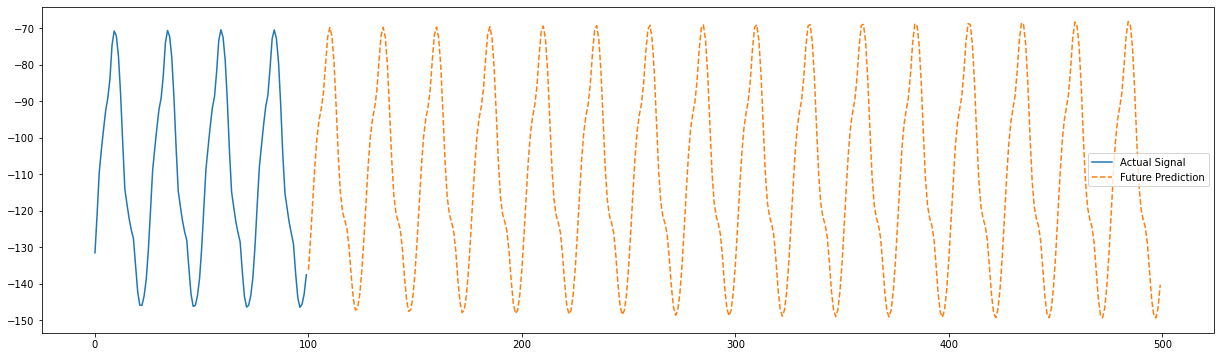

In [9]:
#Train each code using a single LSTM model---LSTM-individual Model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

units_LSTM=100

print(y.shape)
# Generate a sample dataset (replace with your actual data)
data=np.array(np.transpose(y))
print(data.shape)

# Define the sequence length for LSTM
seq_length_collection = [70]#[10,20,30,40,50,60,70,80]
future_steps = pred_time_steps  # Number of future steps to predict

for seq_length in seq_length_collection:
    # Placeholder for reconstructed signals
    reconstructed_signals = []
    future_predictions_lstm = []

    # Loop over each signal
    for idx in range(data.shape[0]):
        start_time = timeit.default_timer()
        
        training_data = data[idx].reshape(data.shape[1],1)
        print('training_data shape:',training_data.shape)
    
        # Normalize the data
        scaler = MinMaxScaler()
        training_data_scaled = scaler.fit_transform(training_data)
    
        # Split the data into train and test sets
        #train_size = int(len(training_data_scaled) * 0.9)
        #train, test = training_data_scaled[:train_size], training_data_scaled[train_size:]
    
        # Prepare the input and output sequences for LSTM
        def create_sequences(data, seq_length):
            xs, ys = [], []
            for i in range(len(data) - seq_length):
                x = data[i:i + seq_length]
                y = data[i + seq_length]
                xs.append(x)
                ys.append(y)
            return np.array(xs), np.array(ys)
    
        X_train, y_train = create_sequences(training_data_scaled, seq_length)
        print(X_train.shape)
        print(y_train.shape)
        #X_test, y_test = create_sequences(test, seq_length)
        #print(X_test.shape)
        #print(y_test.shape)
    
        # Build the LSTM model
        model = Sequential([
            LSTM(units_LSTM, return_sequences=True, input_shape=(seq_length, X_train.shape[2])),
            LSTM(units_LSTM),
            Dense(X_train.shape[2])
        ])
    
        model.compile(optimizer='adam', loss='mean_squared_error')
        
        model.summary()

        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
        model.compile(optimizer=optimizer, loss='mse')        
              
        
        print("the {0} signal".format(idx))
        # Train the model
        #model.fit(X_train, y_train, epochs=2000, batch_size=32, validation_split=0.2)
        # Callbacks
        reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                            factor=0.5,
                                            patience=10,
                                            verbose=1,
                                            mode='min',
                                            min_delta=1e-10,
                                            cooldown=0,
                                            min_lr=0)
        # Train the LSTM model
        model.fit(X_train, y_train,  epochs=500, batch_size=32,validation_split=0.1,callbacks=[reduce_lr])
        print("time spend for training:",timeit.default_timer() - start_time)
      
        # Make predictions
        start_time = timeit.default_timer()
        #predicted_signal_2 = model.predict(X_test)
        #print('predicted_signal_2 shape:',predicted_signal_2.shape)
    
        # Rescale the predicted IMFs
        #predicted_signal = scaler.inverse_transform(predicted_signal_2)
    
        # Store the reconstructed signal
        #reconstructed_signals.append(predicted_signal) 
    
        # Extrapolate future data
        #last_sequence = X_test[-1]
        last_sequence = X_train[-1]
        future_imfs = []
    
        for _ in range(future_steps):
            # Predict the next set of IMFs
            next_imf = model.predict(last_sequence[np.newaxis, :])
            future_imfs.append(next_imf[0])
        
            # Update last_sequence to include the newly predicted IMFs
            last_sequence = np.vstack([last_sequence[1:], next_imf])
    
        # Rescale and sum future IMFs to reconstruct future signal
        future_signal = scaler.inverse_transform(np.array(future_imfs))
        future_predictions_lstm.append(future_signal)
        print("time spend for prediction:",timeit.default_timer() - start_time)
    # Convert lists to numpy arrays
    future_predictions_lstm = np.array(future_predictions_lstm)
    pickle.dump(future_predictions_lstm, open("./Temp_data_Case2/future_predictions_lstm_individual_"+str(seq_length)+'_'+str(encoding_dim)+".pkl", "wb"))

    print(future_predictions_lstm.shape)

    # Plot the actual and predicted signals for the first signal as an example
    #Replace len(reconstructed_signals[idx]) with integer 100
    for idx in range(data.shape[0]):
        plt.figure(figsize=(21, 6))
        plt.plot(data[idx, -100:], label='Actual Signal')
        #plt.plot(reconstructed_signals[idx], label='Predicted Signal', linestyle='dashed')
        plt.plot(np.arange(100, 100+ future_steps), future_predictions_lstm[idx], label='Future Prediction', linestyle='dashed')
        
        plt.legend()
        plt.show()
        

(7, 400, 1)
(7, 400)
(7, 1601)
(100,)
(400, 1)
(7, 400)


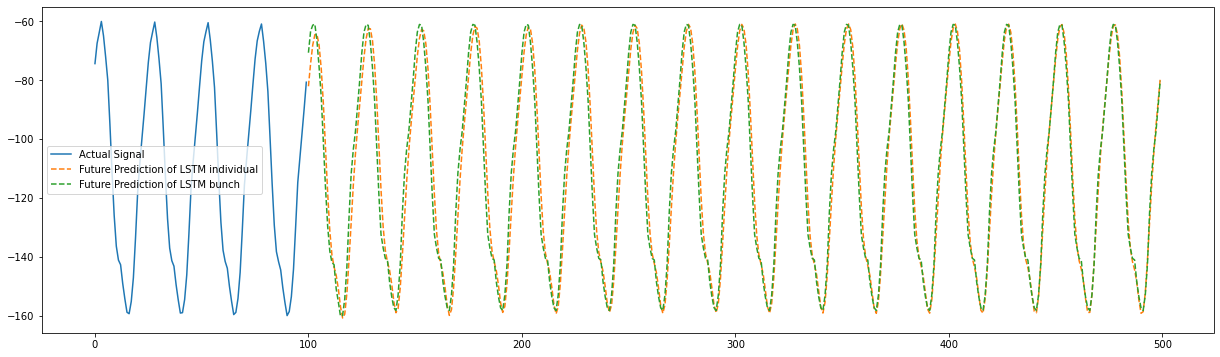

(100,)
(400, 1)
(7, 400)


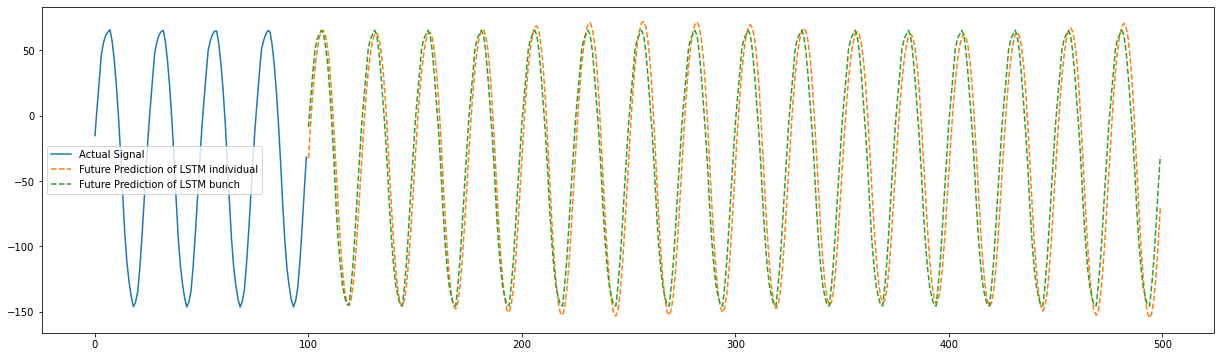

(100,)
(400, 1)
(7, 400)


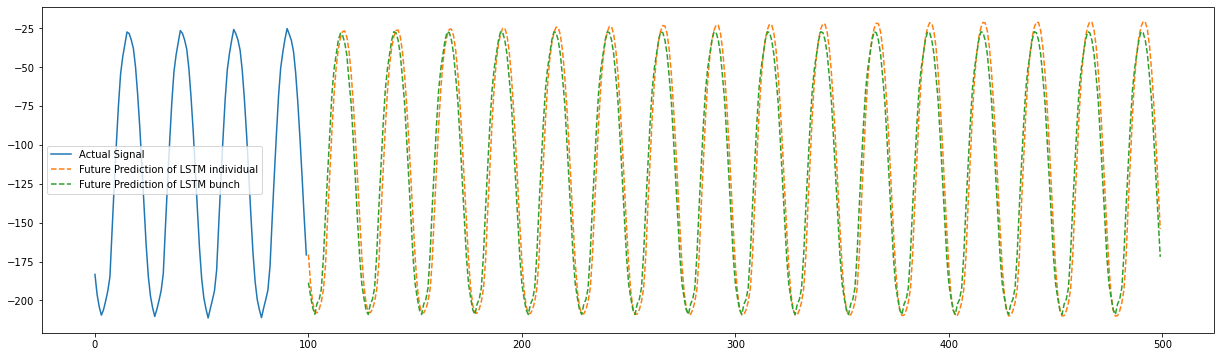

(100,)
(400, 1)
(7, 400)


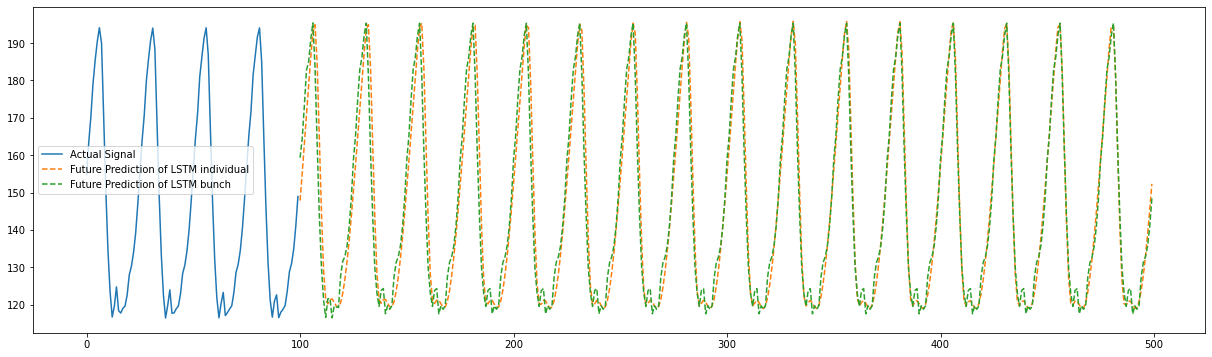

(100,)
(400, 1)
(7, 400)


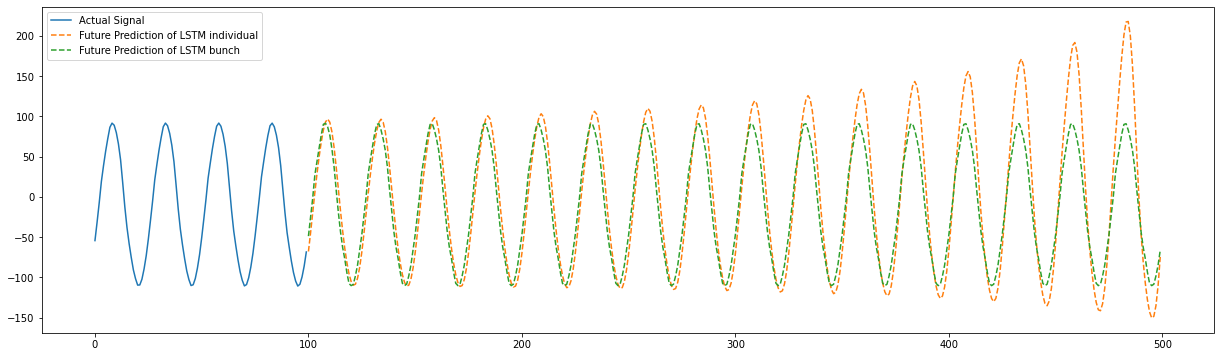

(100,)
(400, 1)
(7, 400)


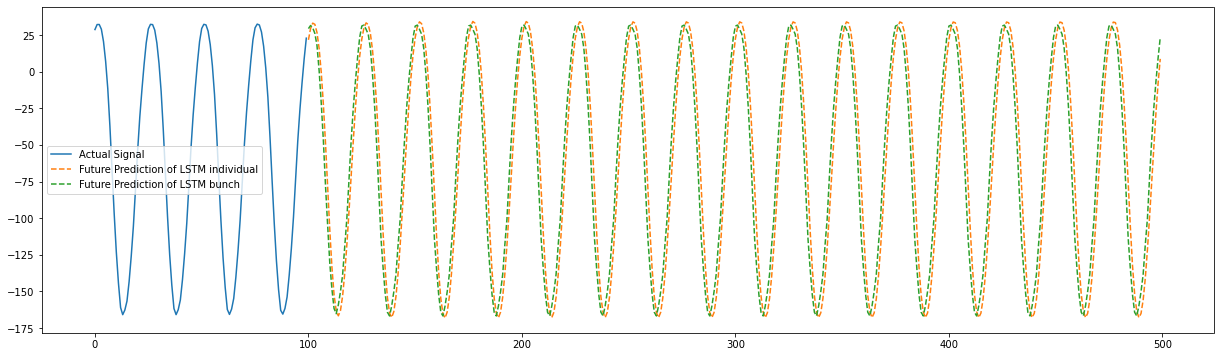

(100,)
(400, 1)
(7, 400)


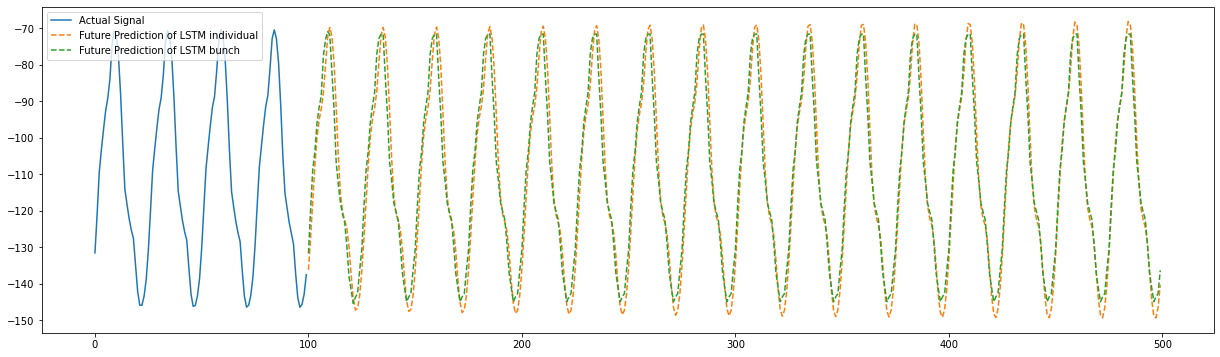

In [10]:
seq_length=70
future_predictions_lstm=joblib.load(open("./Temp_data_Case2/future_predictions_lstm_individual_"+str(seq_length)+'_'+str(encoding_dim)+".pkl", "rb"))
print(future_predictions_lstm.shape)
future_latent_predictions_lstm_bunch=np.transpose(joblib.load(open("./Temp_data_Case2/reconstructed_signals_lstm_codes_"+str(encoding_dim)+".pkl", "rb")))
print(future_latent_predictions_lstm_bunch.shape)

data=np.array(np.transpose(y))
print(data.shape)
# Plot the actual and predicted codes (both LSTM-individual and LSTM-bunch) for comparison
for idx in range(data.shape[0]):
    plt.figure(figsize=(21, 6))
    print(data[idx, -100:].shape)
    plt.plot(data[idx, -100:], label='Actual Signal')
    
    print(future_predictions_lstm[idx].shape)
    plt.plot(np.arange(100, 100 + future_steps), future_predictions_lstm[idx], label='Future Prediction of LSTM individual', linestyle='dashed')
    print(future_latent_predictions_lstm_bunch.shape)
    plt.plot(np.arange(100, 100 + future_steps), future_latent_predictions_lstm_bunch[idx], label='Future Prediction of LSTM bunch', linestyle='dashed')
    plt.legend()
    plt.show()

In [5]:
#import DMD model
from dmd_machine.DMD import *
#The prediction result of SAE-DMD model in different code length
future_steps=pred_time_steps
dmd=DMD()
# start timer.
start_time = timeit.default_timer()

print("y.shape",y.shape)
y_pred = dmd.get_predicted_y(tf.transpose(y),int(encoding_dim),future_steps)# rank equals 10 and estimate time step equals 10
print("y_pred_before_transpose",y_pred.shape)

print("time spend for prediction:",timeit.default_timer() - start_time)


y.shape (1601, 7)
Singular value matrix's shape (7,)
Singular value array [10134.124    4519.756    3162.253    2399.1382   1161.9547    477.85632
    56.90613]
(7, 7)
y_pred_before_transpose (7, 1601)
time spend for prediction: 0.01241491899418179


Original code (7, 1601)
DMD predict (7, 1601)
(7, 400, 1)
LSTM predict (7, 400)
LSTM predict&original (7, 1601)
(7, 400)
(7, 1601)
LSTM predict_bunch&original (7, 1601)


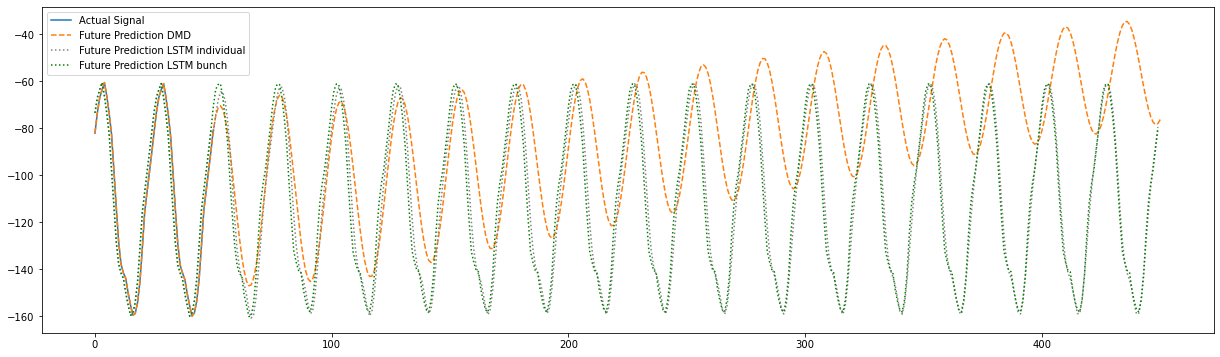

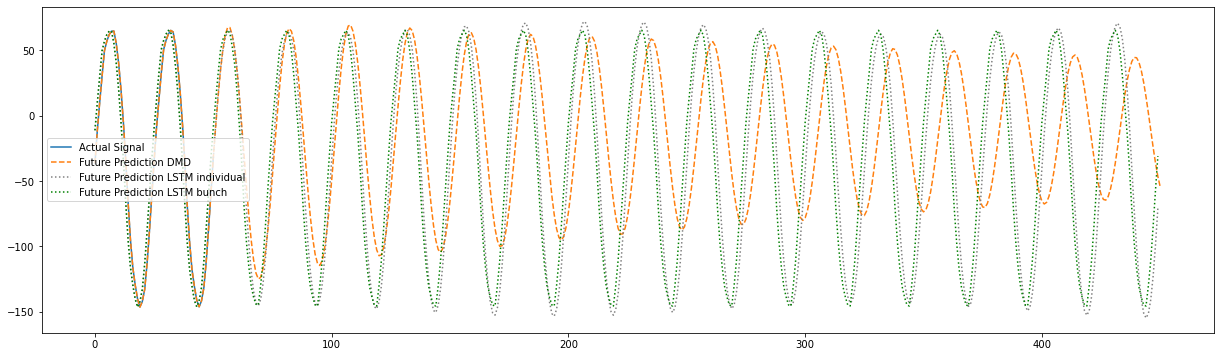

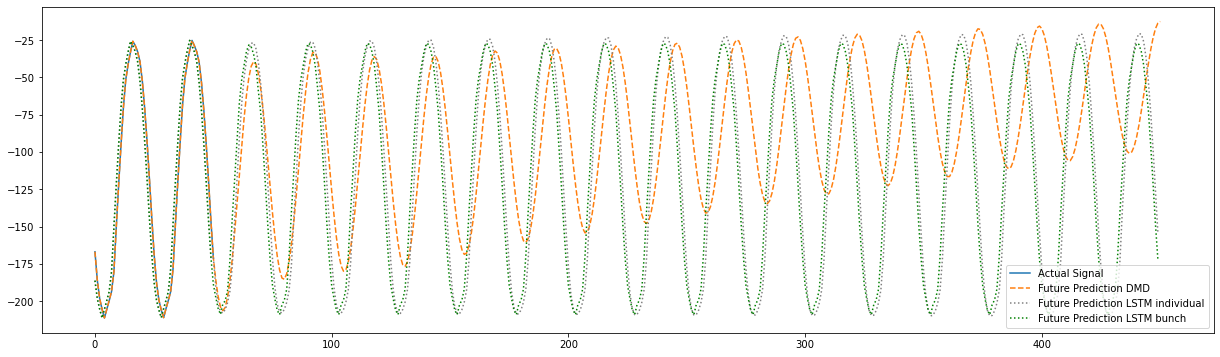

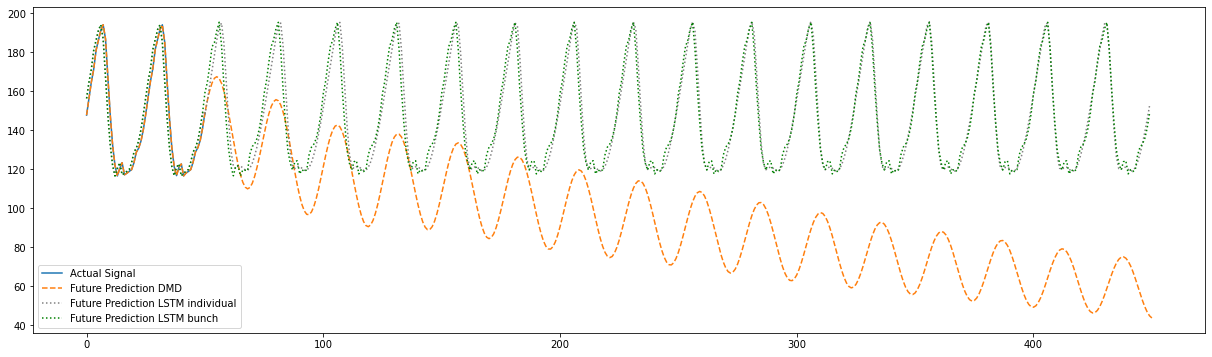

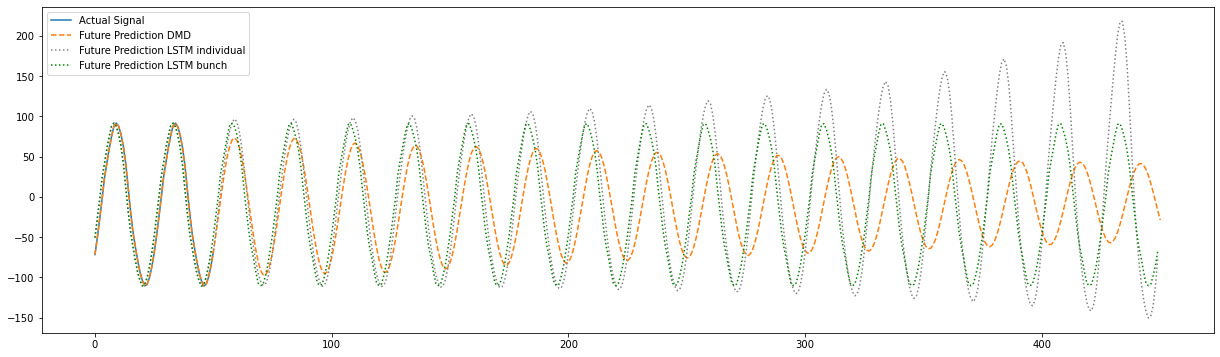

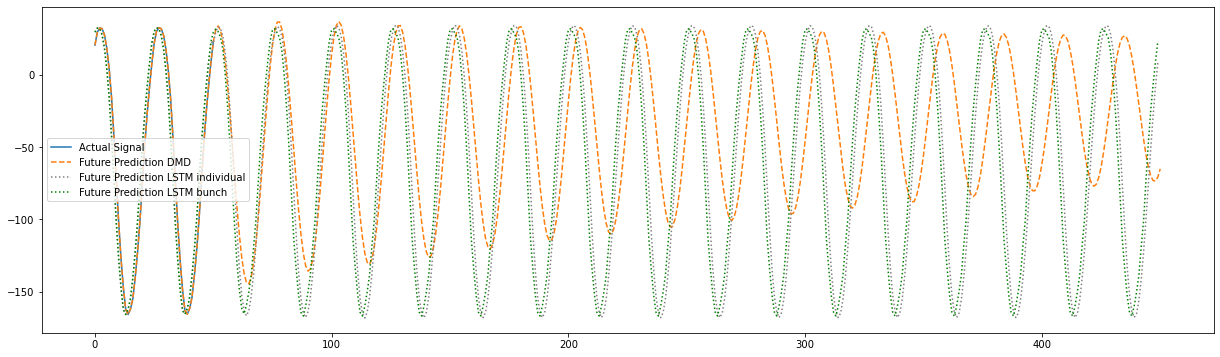

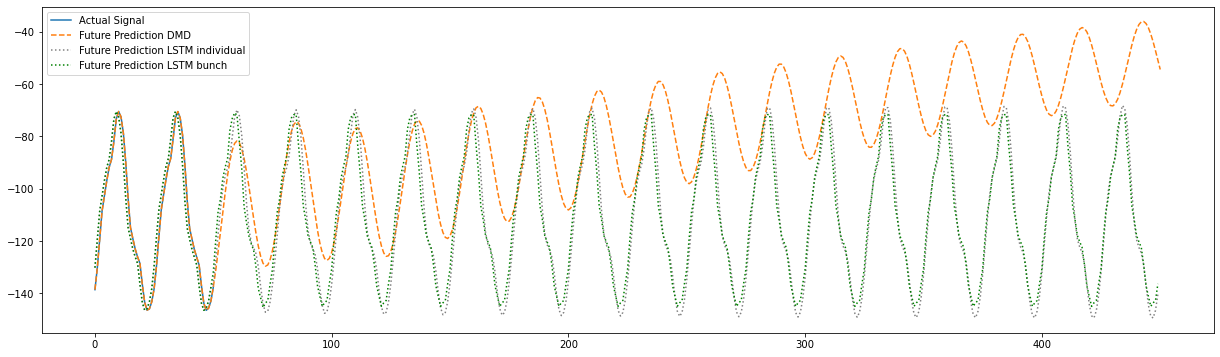

In [11]:
y_original=tf.transpose(y)
print("Original code",y_original.shape)

y_pred = np.array(y_pred)
pickle.dump(y_pred, open("./Temp_data_Case2/reconstructed_signals_dmd_"+str(encoding_dim)+".pkl", "wb"))

print("DMD predict",y_pred.shape)

seq_length=70
future_predictions_lstm=joblib.load(open("./Temp_data_Case2/future_predictions_lstm_individual_"+str(seq_length)+'_'+str(encoding_dim)+".pkl", 'rb'))
print(future_predictions_lstm.shape)
future_predictions_lstm_reshape=np.reshape(future_predictions_lstm,(encoding_dim,-1))
print("LSTM predict",future_predictions_lstm_reshape.shape)
future_predictions_lstm_combine=np.transpose(np.vstack((np.transpose(y_original[:,400:]),np.transpose(future_predictions_lstm_reshape))))
print("LSTM predict&original",future_predictions_lstm_combine.shape)

future_latent_predictions_lstm_bunch=np.transpose(joblib.load(open("./Temp_data_Case2/reconstructed_signals_lstm_codes_"+str(encoding_dim)+".pkl", "rb")))
print(future_latent_predictions_lstm_bunch.shape)
print(y_original.shape)
future_predictions_lstm_combine_bunch=np.transpose(np.vstack((np.transpose(y_original[:,400:]),np.transpose(future_latent_predictions_lstm_bunch))))
print("LSTM predict_bunch&original",future_predictions_lstm_combine_bunch.shape)

# Plot the actual and predicted signals for the first signal as an example
for idx in range(y_original.shape[0]):
    plt.figure(figsize=(21, 6))
    plt.plot(y_original[idx, -(51):], label='Actual Signal')
    plt.plot(y_pred[idx, -(51+future_steps):], label='Future Prediction DMD', linestyle='dashed')
    plt.plot(future_predictions_lstm_combine[idx, -(50+future_steps):], label='Future Prediction LSTM individual', color='grey',linestyle='dotted')
    plt.plot(future_predictions_lstm_combine_bunch[idx, -(50+future_steps):], label='Future Prediction LSTM bunch', color='green',linestyle='dotted')
    plt.legend()
    plt.show()

In [6]:
#Reconstruct the code into the origin like array
def recontruction(ae,code):
    code_transp=np.transpose(code)
    x_ae=ae.decoder(code_transp)
    print(x_ae.shape)
    outputs=np.array(x_ae).reshape(code_transp.shape[0],55268,2)
    u = outputs[:,:,0]
    v = outputs[:,:,1]
    scaler_u = joblib.load('./data/case2data/scaler_u.pkl')
    scaler_v = joblib.load('./data/case2data/scaler_v.pkl')
    outputs_u = scaler_u.inverse_transform(u)
    outputs_v = scaler_v.inverse_transform(v)
    outputs = np.dstack((outputs_u, outputs_v))   
    return outputs

#Inverse scale the reconstructed data into the origin like array
def scalar_inverse(reconstructed_data):
    outputs=np.array(reconstructed_data).reshape(reconstructed_data.shape[0],55268,2)
    u = outputs[:,:,0]
    v = outputs[:,:,1]
    scaler_u = joblib.load('./data/case2data/scaler_u.pkl')
    scaler_v = joblib.load('./data/case2data/scaler_v.pkl')
    outputs_u = scaler_u.inverse_transform(u)
    outputs_v = scaler_v.inverse_transform(v)
    outputs = np.dstack((outputs_u, outputs_v))   
    return outputs 

#Calculat the magnitude of the velocity on x and y direction
def cal_Magnitude(data):
    three_dimension_data=np.array(data).transpose(1,2,0)

    two_dimension_data=np.zeros((three_dimension_data.shape[0], three_dimension_data.shape[2]), dtype=np.float32)
    #print(two_dimension_data.shape)
    for i in range(0, three_dimension_data.shape[0]):
        for j in range(0, three_dimension_data.shape[2]):
            magnitude=math.sqrt(pow(three_dimension_data[i,0,j],2)+pow(three_dimension_data[i,1,j],2))
            two_dimension_data[i][j]=magnitude
    two_dimension_data=two_dimension_data.reshape(two_dimension_data.shape[1],two_dimension_data.shape[0])
    return two_dimension_data

In [ ]:
#Comparsion of reconstruction accuracy between SAE and POD in different code length
import joblib
import math
import numpy as np
import pickle

# start timer.
start_time = timeit.default_timer()

ori_data = np.load(open('./data/case2data/U.npy', 'rb'))[1201:1601]
print(ori_data.shape)
ori_data3=cal_Magnitude(ori_data)
pickle.dump(ori_data3, open("./Temp_data_Case2/ori_data3.pkl", "wb"))

rom_data_0=joblib.load(open("./Temp_data_Case2/reconstructed_data_7_POD.pkl", "rb"))[1201:1601]
rom_data_03=cal_Magnitude(scalar_inverse(rom_data_0))
pickle.dump(rom_data_03, open("./Temp_data_Case2/rom_data_03.pkl", "wb"))

rom_data_1=joblib.load(open("./Temp_data_Case2/reconstructed_data_12_POD.pkl", "rb"))[1201:1601]#
rom_data_13=cal_Magnitude(scalar_inverse(rom_data_1))
pickle.dump(rom_data_13, open("./Temp_data_Case2/rom_data_13.pkl", "wb"))

rom_data_2=joblib.load(open("./Temp_data_Case2/reconstructed_data_35_POD.pkl", "rb"))[1201:1601]
rom_data_23=cal_Magnitude(scalar_inverse(rom_data_2))
pickle.dump(rom_data_23, open("./Temp_data_Case2/rom_data_23.pkl", "wb"))

rom_data_3=joblib.load(open("./Temp_data_Case2/reconstructed_data_7_SAE.pkl", "rb"))[1201:1601]
rom_data_33=cal_Magnitude(scalar_inverse(rom_data_3))
pickle.dump(rom_data_33, open("./Temp_data_Case2/rom_data_33.pkl", "wb"))

rom_data_4=joblib.load(open("./Temp_data_Case2/reconstructed_data_12_SAE.pkl", "rb"))[1201:1601]
rom_data_43=cal_Magnitude(scalar_inverse(rom_data_4))
pickle.dump(rom_data_43, open("./Temp_data_Case2/rom_data_43.pkl", "wb"))

rom_data_5=joblib.load(open("./Temp_data_Case2/reconstructed_data_35_SAE.pkl", "rb"))[1201:1601]
rom_data_53=cal_Magnitude(scalar_inverse(rom_data_5))
pickle.dump(rom_data_53, open("./Temp_data_Case2/rom_data_53.pkl", "wb"))

print("time spend for prediction:",timeit.default_timer() - start_time)

In [11]:
ori_data2=joblib.load(open('./Temp_data_Case2/ori_data3.pkl', 'rb'))

rom_data_02=joblib.load(open('./Temp_data_Case2/rom_data_03.pkl', 'rb'))
rom_data_12=joblib.load(open('./Temp_data_Case2/rom_data_13.pkl', 'rb'))
rom_data_22=joblib.load(open('./Temp_data_Case2/rom_data_23.pkl', 'rb'))
rom_data_32=joblib.load(open('./Temp_data_Case2/rom_data_33.pkl', 'rb'))
rom_data_42=joblib.load(open('./Temp_data_Case2/rom_data_43.pkl', 'rb'))
rom_data_52=joblib.load(open('./Temp_data_Case2/rom_data_53.pkl', 'rb'))
from dmd_machine import Model_Processing_7inputs_2_SAE_POD as MP7

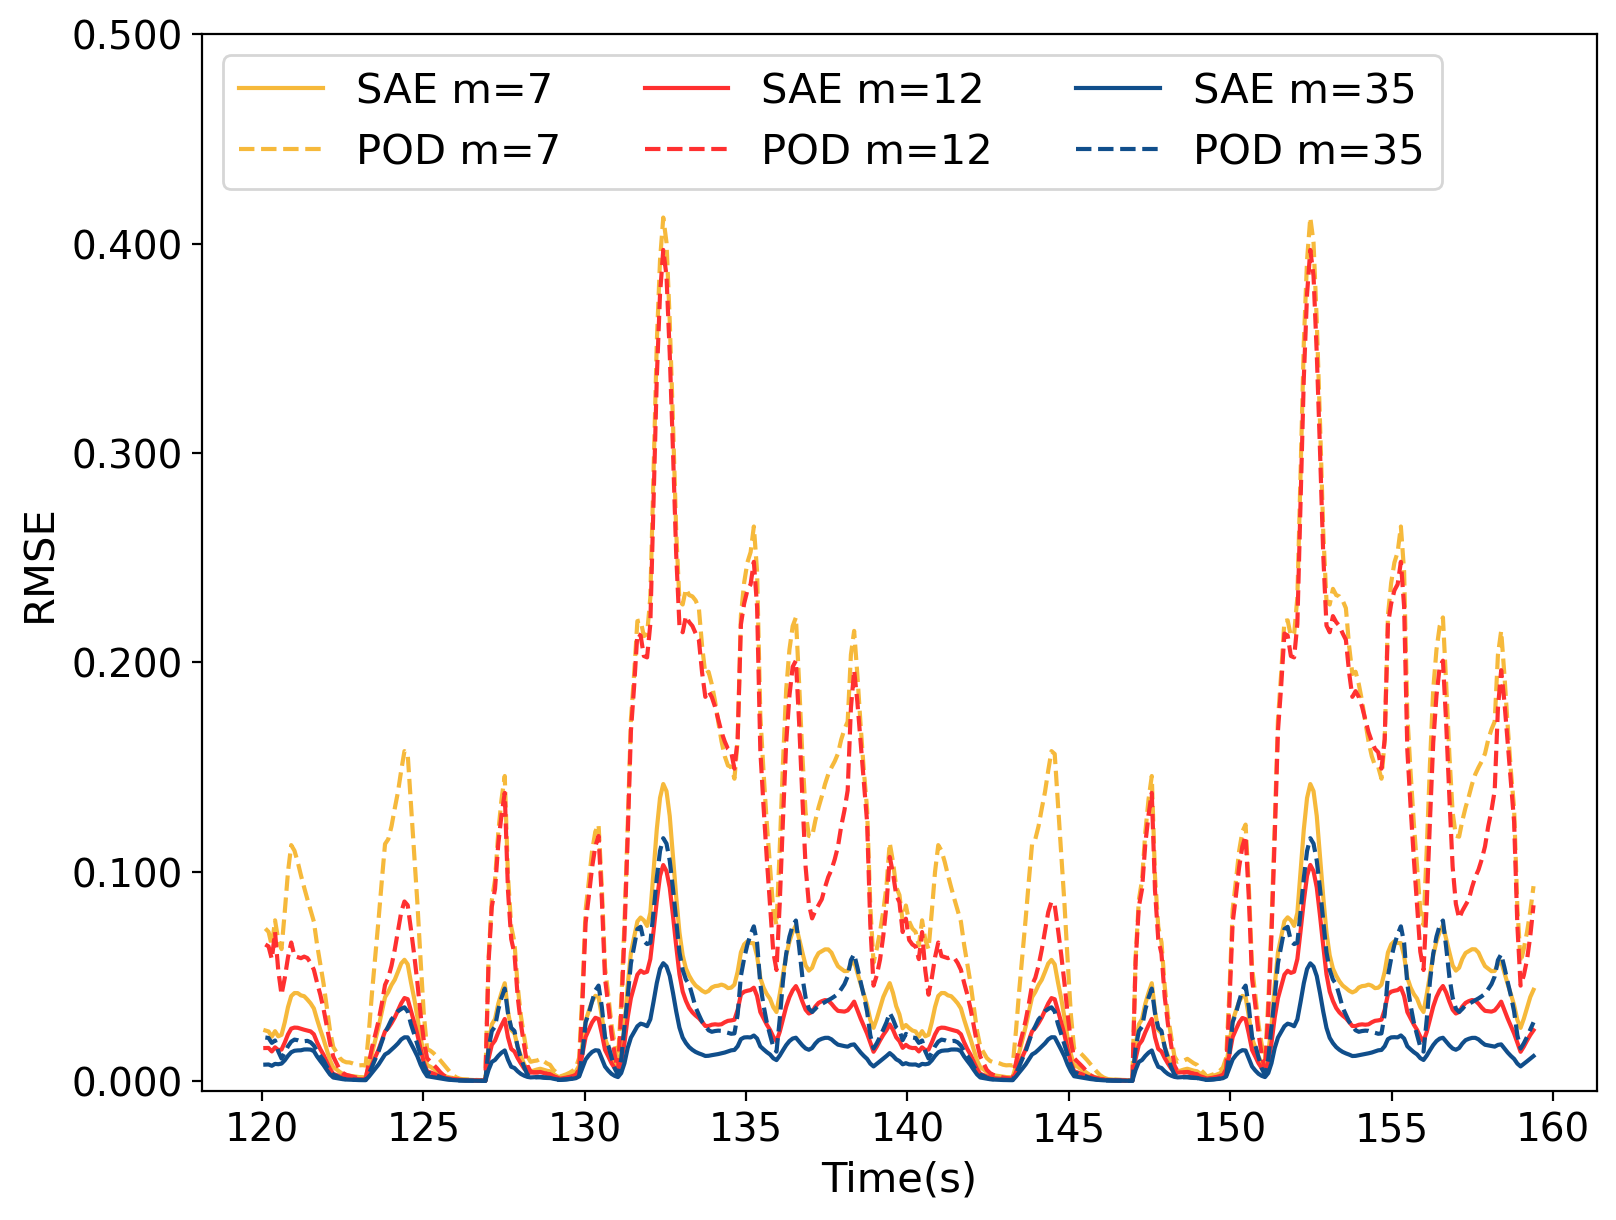

In [12]:
MP7.rmse_over_time(ori_data2, rom_data_32, rom_data_02,rom_data_42, rom_data_12,rom_data_52, rom_data_22,'U',0.5,120)


/home/chuanhua/anaconda3/envs/venv_ROM/lib/python3.6/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/chuanhua/anaconda3/envs/venv_ROM/lib/python3.6/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


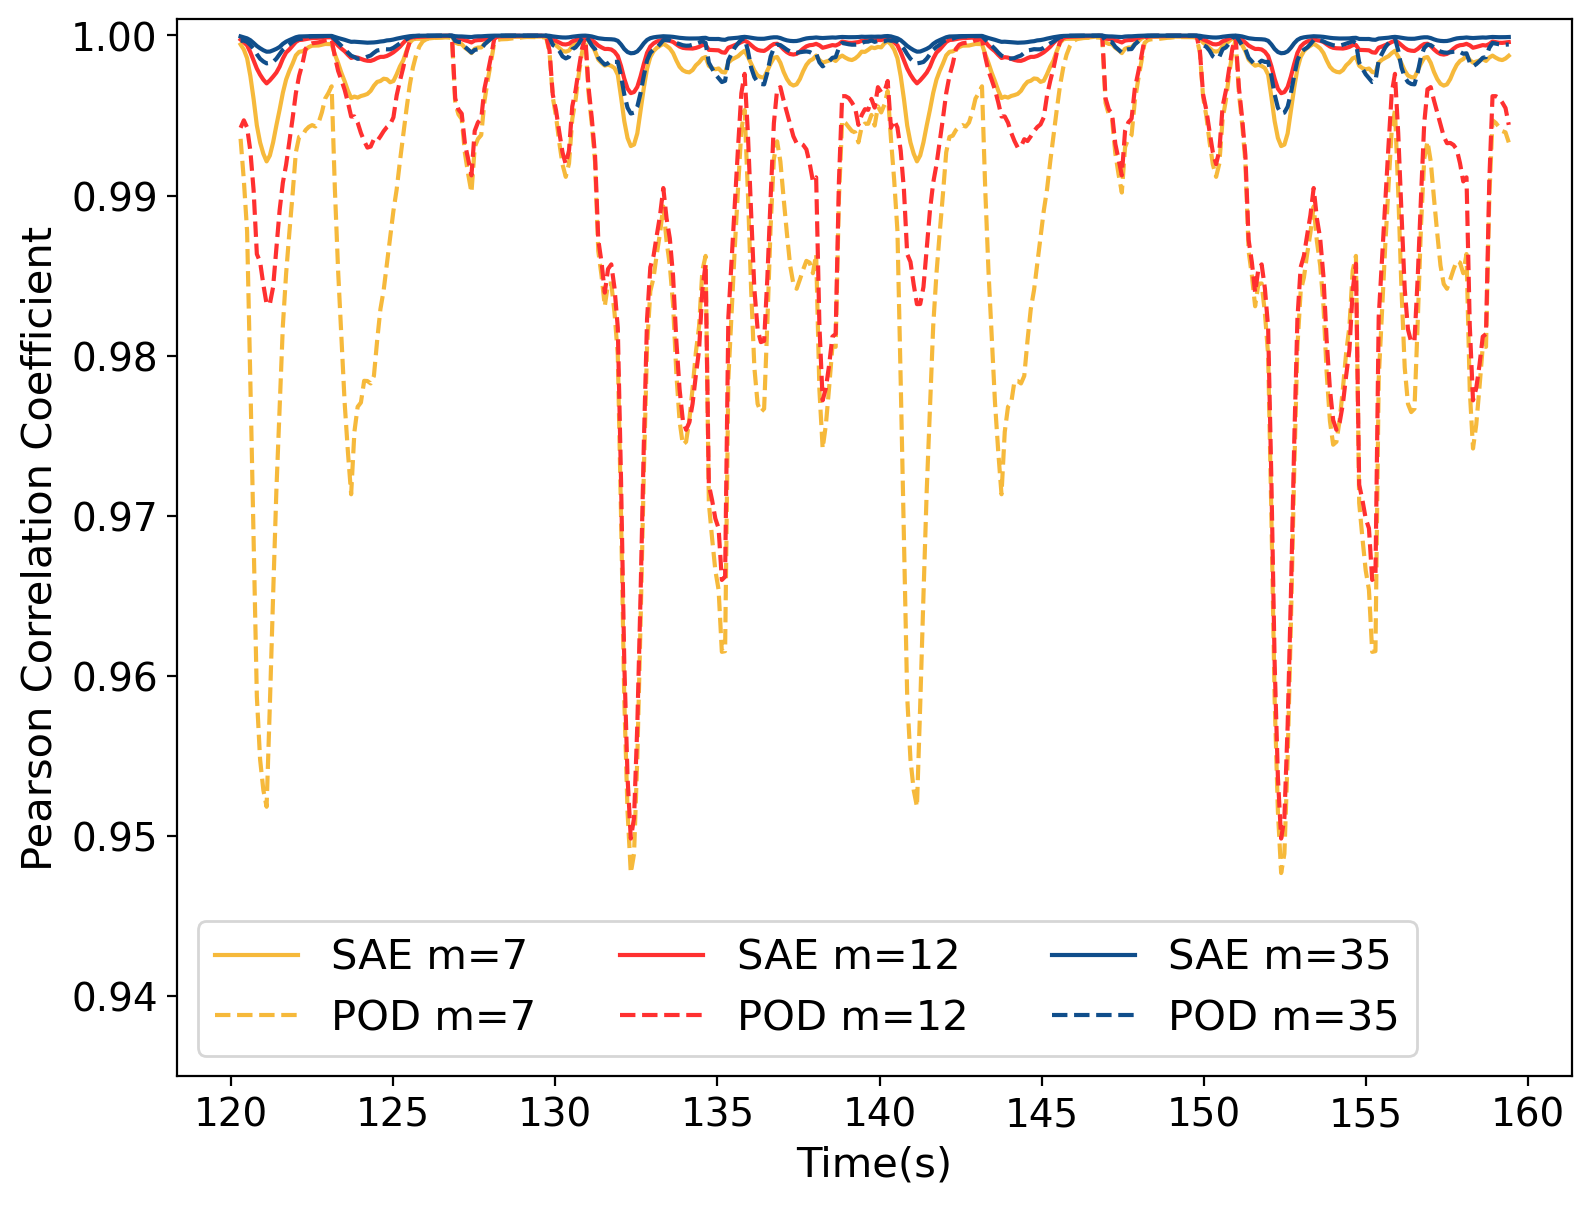

In [13]:
MP7.cc7(ori_data2, rom_data_32, rom_data_02,rom_data_42, rom_data_12,rom_data_52, rom_data_22,0.935,'U',120)

In [ ]:
#Parametric study of the sequence length for training the LSTM-individual model
import joblib
import math
import numpy as np
import pickle
encoding_dim =7 #[7,12,35]
model_save_folder = './AE_Models_case2'
encoder_file_name = 'AE_encoder_dim' + str(encoding_dim) # name of encoder model
decoder_file_name = 'AE_decoder_dim' + str(encoding_dim) # name of decoder model
AE_file_name = 'AE_dim' + str(encoding_dim) # name of AE whole model

ae = StackAutoencoder()
ae.encoder = load_model(model_save_folder + "/" + encoder_file_name)
ae.decoder = load_model(model_save_folder + "/" + decoder_file_name)

print(np.load(open('./data/case2data/U.npy', 'rb')).shape)#[2001,55268, 2]
ori_data2=cal_Magnitude(np.load(open('./data/case2data/U.npy', 'rb'))[-400:])# 
print(ori_data2.shape)
pickle.dump(ori_data2, open("./Temp_data_Case2/ori_data2.pkl", "wb"))

future_predictions_lstm_bunch=joblib.load(open("./Temp_data_Case2/future_predictions_lstm_individual_"+str(10)+'_'+str(encoding_dim)+".pkl", 'rb')).squeeze()
print(future_predictions_lstm_bunch.shape)
rom_data_individual_10=cal_Magnitude(recontruction(ae,future_predictions_lstm_bunch[:,-400:]))
pickle.dump(rom_data_individual_10, open("./Temp_data_Case2/rom_data_individual_10.pkl", "wb"))

future_predictions_lstm_bunch=joblib.load(open("./Temp_data_Case2/future_predictions_lstm_individual_"+str(20)+'_'+str(encoding_dim)+".pkl", 'rb')).squeeze()
print(future_predictions_lstm_bunch.shape)
rom_data_individual_20=cal_Magnitude(recontruction(ae,future_predictions_lstm_bunch[:,-400:]))
pickle.dump(rom_data_individual_20, open("./Temp_data_Case2/rom_data_individual_20.pkl", "wb"))

future_predictions_lstm_bunch=joblib.load(open("./Temp_data_Case2/future_predictions_lstm_individual_"+str(30)+'_'+str(encoding_dim)+".pkl", 'rb')).squeeze()
print(future_predictions_lstm_bunch.shape)
rom_data_individual_30=cal_Magnitude(recontruction(ae,future_predictions_lstm_bunch[:,-400:]))
pickle.dump(rom_data_individual_30, open("./Temp_data_Case2/rom_data_individual_30.pkl", "wb"))

future_predictions_lstm_bunch=joblib.load(open("./Temp_data_Case2/future_predictions_lstm_individual_"+str(40)+'_'+str(encoding_dim)+".pkl", 'rb')).squeeze()
print(future_predictions_lstm_bunch.shape)
rom_data_individual_40=cal_Magnitude(recontruction(ae,future_predictions_lstm_bunch[:,-400:]))
pickle.dump(rom_data_individual_40, open("./Temp_data_Case2/rom_data_individual_40.pkl", "wb"))

future_predictions_lstm_bunch=joblib.load(open("./Temp_data_Case2/future_predictions_lstm_individual_"+str(50)+'_'+str(encoding_dim)+".pkl", 'rb')).squeeze()
print(future_predictions_lstm_bunch.shape)
rom_data_individual_50=cal_Magnitude(recontruction(ae,future_predictions_lstm_bunch[:,-400:]))
pickle.dump(rom_data_individual_50, open("./Temp_data_Case2/rom_data_individual_50.pkl", "wb"))

future_predictions_lstm_bunch=joblib.load(open("./Temp_data_Case2/future_predictions_lstm_individual_"+str(60)+'_'+str(encoding_dim)+".pkl", 'rb')).squeeze()
print(future_predictions_lstm_bunch.shape)
rom_data_individual_60=cal_Magnitude(recontruction(ae,future_predictions_lstm_bunch[:,-400:]))
pickle.dump(rom_data_individual_60, open("./Temp_data_Case2/rom_data_individual_60.pkl", "wb"))

future_predictions_lstm_bunch=joblib.load(open("./Temp_data_Case2/future_predictions_lstm_individual_"+str(70)+'_'+str(encoding_dim)+".pkl", 'rb')).squeeze()
print(future_predictions_lstm_bunch.shape)
rom_data_individual_70=cal_Magnitude(recontruction(ae,future_predictions_lstm_bunch[:,-400:]))
pickle.dump(rom_data_individual_70, open("./Temp_data_Case2/rom_data_individual_70.pkl", "wb"))

future_predictions_lstm_bunch=joblib.load(open("./Temp_data_Case2/future_predictions_lstm_individual_"+str(80)+'_'+str(encoding_dim)+".pkl", 'rb')).squeeze()
print(future_predictions_lstm_bunch.shape)
rom_data_individual_80=cal_Magnitude(recontruction(ae,future_predictions_lstm_bunch[:,-400:]))
pickle.dump(rom_data_individual_80, open("./Temp_data_Case2/rom_data_individual_80.pkl", "wb"))


In [14]:
ori_data2=joblib.load(open("./Temp_data_Case2/ori_data2.pkl", 'rb'))
rom_data_individual_10=joblib.load(open("./Temp_data_Case2/rom_data_individual_10.pkl", 'rb'))
rom_data_individual_20=joblib.load(open("./Temp_data_Case2/rom_data_individual_20.pkl", 'rb'))
rom_data_individual_30=joblib.load(open("./Temp_data_Case2/rom_data_individual_30.pkl", 'rb'))
rom_data_individual_40=joblib.load(open("./Temp_data_Case2/rom_data_individual_40.pkl", 'rb'))
rom_data_individual_50=joblib.load(open("./Temp_data_Case2/rom_data_individual_50.pkl", 'rb'))
rom_data_individual_60=joblib.load(open("./Temp_data_Case2/rom_data_individual_60.pkl", 'rb'))
rom_data_individual_70=joblib.load(open("./Temp_data_Case2/rom_data_individual_70.pkl", 'rb'))
rom_data_individual_80=joblib.load(open("./Temp_data_Case2/rom_data_individual_80.pkl", 'rb'))    
from dmd_machine import Model_Processing_9inputs_2_seq_lenght as MP9
    

/home/chuanhua/anaconda3/envs/venv_ROM/lib/python3.6/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/chuanhua/anaconda3/envs/venv_ROM/lib/python3.6/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


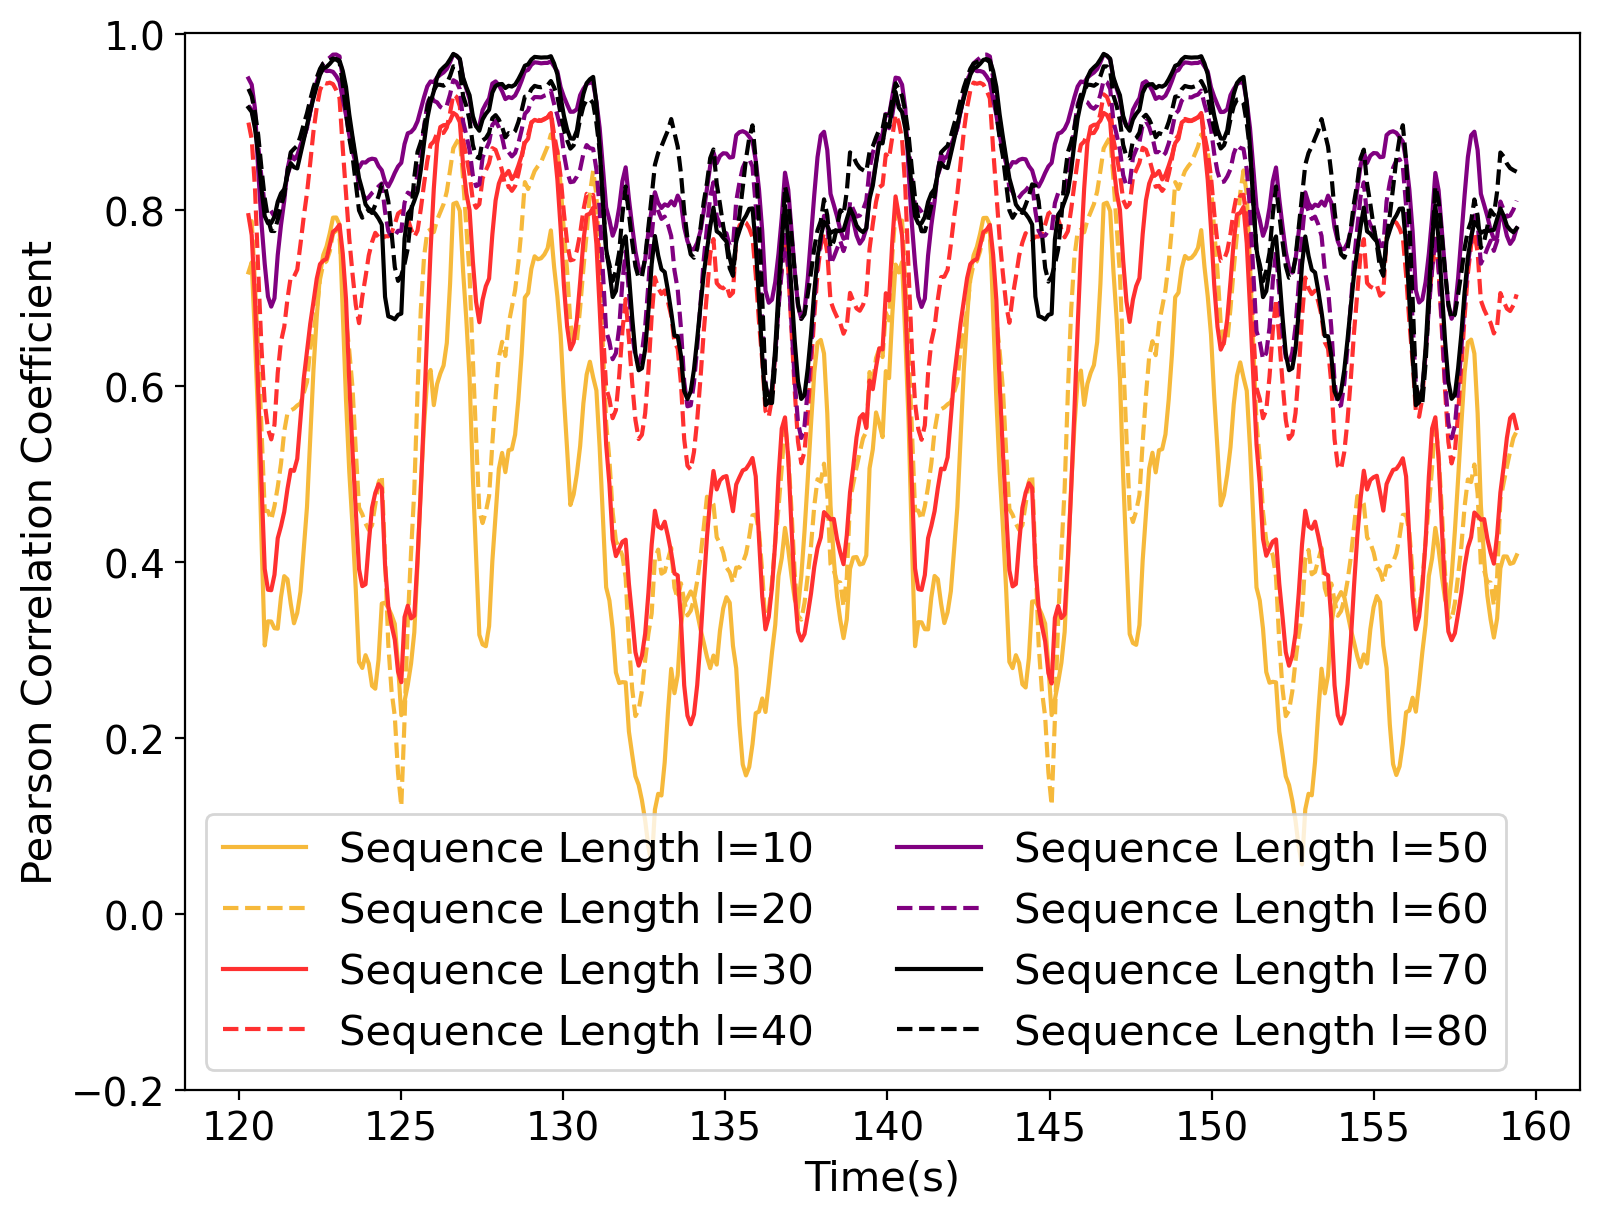

In [16]:
MP9.cc9(ori_data2, rom_data_individual_10, rom_data_individual_20, rom_data_individual_30, rom_data_individual_40,rom_data_individual_50, rom_data_individual_60,rom_data_individual_70, rom_data_individual_80,-0.2,'U',120,2)

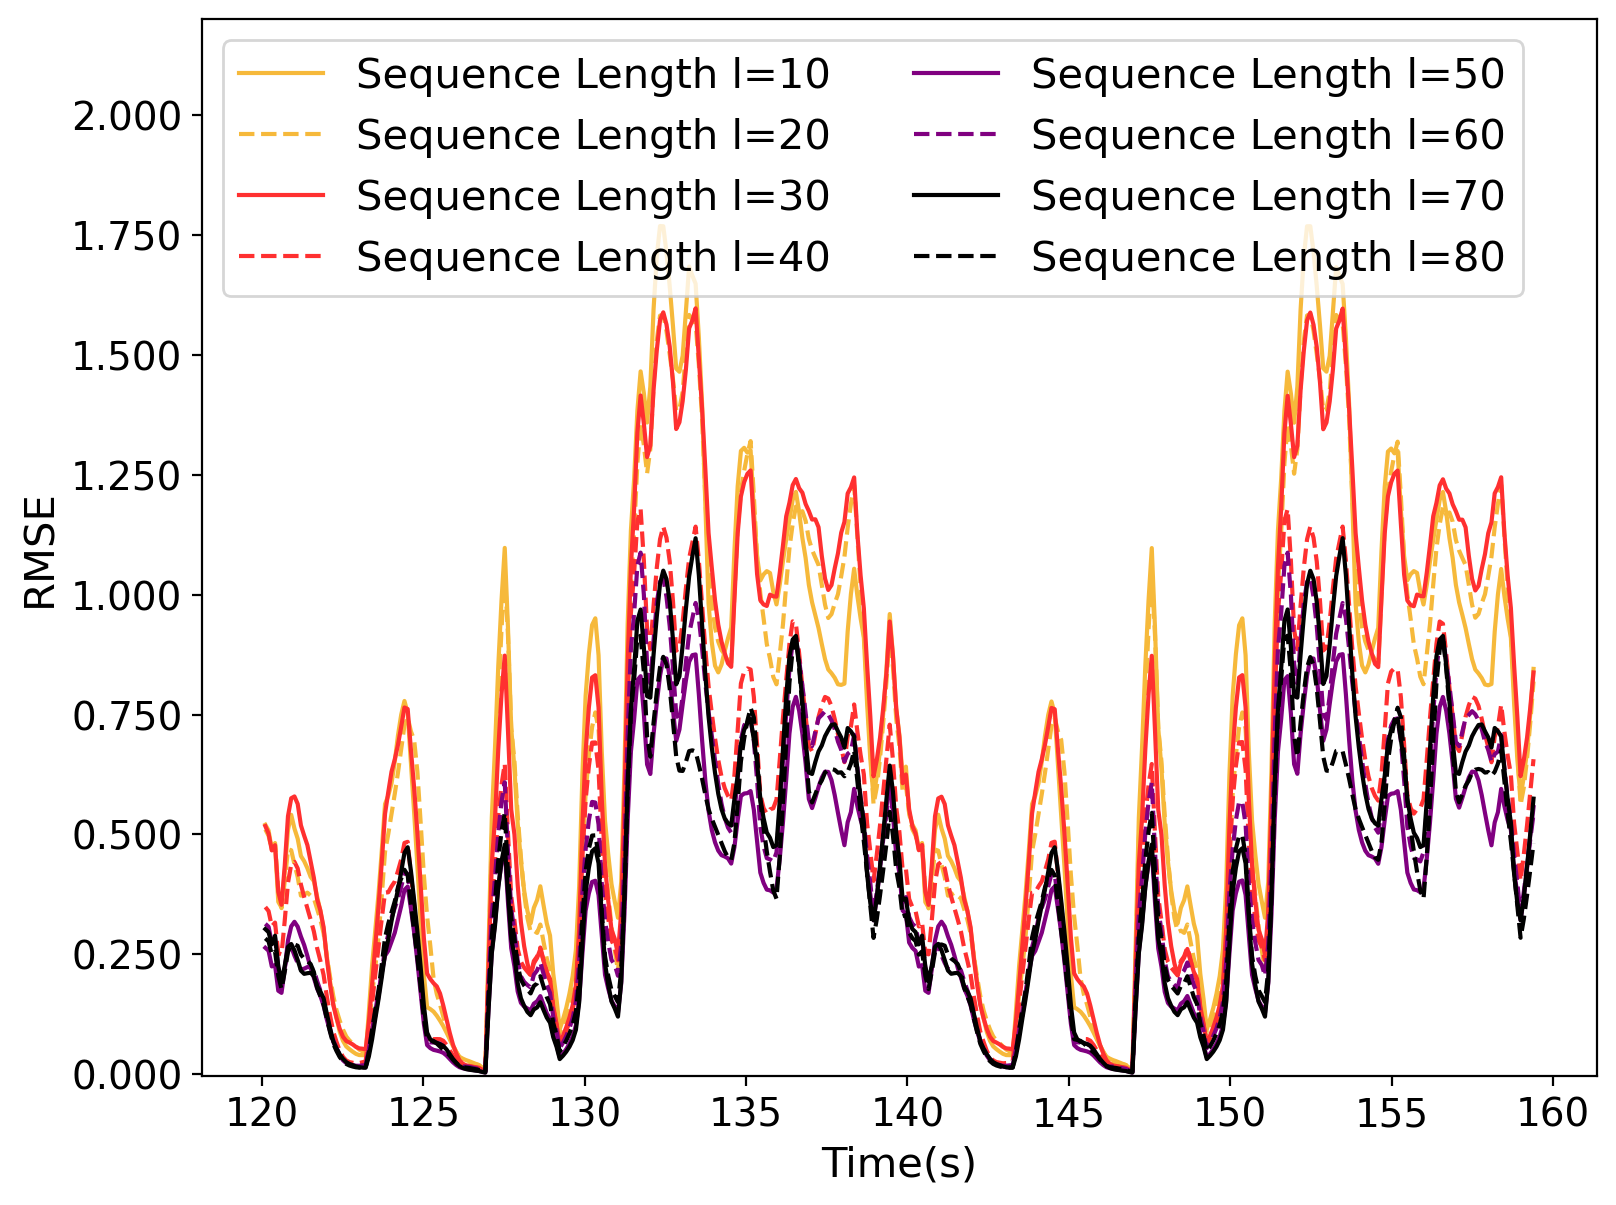

In [15]:
MP9.rmse_over_time(ori_data2, rom_data_individual_10, rom_data_individual_20, rom_data_individual_30, rom_data_individual_40,rom_data_individual_50, rom_data_individual_60,rom_data_individual_70, rom_data_individual_80,'U', 2.2, 120,2)

In [ ]:
#Prediction comparison of three different models
import joblib
import pickle
encoding_dim =7#[7,12,35]
model_save_folder = './AE_Models_case2'
encoder_file_name = 'AE_encoder_dim' + str(encoding_dim) # name of encoder model
decoder_file_name = 'AE_decoder_dim' + str(encoding_dim) # name of decoder model
AE_file_name = 'AE_dim' + str(encoding_dim) # name of AE whole model

ae = StackAutoencoder()
ae.encoder = load_model(model_save_folder + "/" + encoder_file_name)
ae.decoder = load_model(model_save_folder + "/" + decoder_file_name)

print(np.load(open('./data/case2data/U.npy', 'rb')).shape)#[2001,55268, 2]
ori_data2=cal_Magnitude(np.load(open('./data/case2data/U.npy', 'rb'))[-400:])# 
print(ori_data2.shape)
pickle.dump(ori_data2, open("./Temp_data_Case2/ori_data2.pkl", "wb"))

seq_length=70

future_predictions_lstm_individual=(joblib.load(open("./Temp_data_Case2/future_predictions_lstm_individual_"+str(seq_length)+'_'+str(encoding_dim)+".pkl", 'rb'))).squeeze()
print(future_predictions_lstm_individual.shape)
rom_data_02=cal_Magnitude(recontruction(ae,future_predictions_lstm_individual[:,-400:]))
print(rom_data_02.shape)
pickle.dump(rom_data_02, open("./Temp_data_Case2/rom_data_02.pkl", "wb"))

y_pred=joblib.load(open("./Temp_data_Case2/reconstructed_signals_dmd_"+str(encoding_dim)+".pkl", 'rb'))
print(y_pred.shape)
rom_data_12=cal_Magnitude(recontruction(ae,y_pred[:,-400:]))#
print(rom_data_12.shape)
pickle.dump(rom_data_12, open("./Temp_data_Case2/rom_data_12.pkl", "wb"))

future_predictions_lstm_bunch=np.transpose(joblib.load(open("./Temp_data_Case2/reconstructed_signals_lstm_codes_"+str(encoding_dim)+".pkl", 'rb')))
print(future_predictions_lstm_bunch.shape)
rom_data_22=cal_Magnitude(recontruction(ae,future_predictions_lstm_bunch[:,-400:]))
print(rom_data_22.shape)
pickle.dump(rom_data_22, open("./Temp_data_Case2/rom_data_22.pkl", "wb"))
#

In [37]:
ori_data2=joblib.load(open('./Temp_data_Case2/ori_data2.pkl', 'rb'))
rom_data_02=joblib.load(open('./Temp_data_Case2/rom_data_02.pkl', 'rb'))
rom_data_12=joblib.load(open('./Temp_data_Case2/rom_data_12.pkl', 'rb'))
rom_data_22=joblib.load(open('./Temp_data_Case2/rom_data_22.pkl', 'rb'))
from dmd_machine import Model_Processing_4inputs_2 as MP4


In [ ]:
MP4.rmse_over_time(ori_data2, rom_data_22, rom_data_02,rom_data_12,'U',0.9,160,'upper left',3)

In [ ]:
MP4.cc4(ori_data2, rom_data_22, rom_data_02,rom_data_12,0.75,'U',160,'lower left',3)

# ***Output***

In [33]:
#Output the point over time of various-lengthe SAE-LSTM-bunch model, and the selected point ID is 26621 in the following code snippets.
print(np.load(open('./data/case2data/U.npy', 'rb')).shape)#[2001,55268, 2]
ori_data2=np.load(open('./data/case2data/U.npy', 'rb'))[-400:]
pickle.dump(ori_data2, open("./Temp_data_Case2/ori_data2.pkl", "wb"))
ori_data02=cal_Magnitude(ori_data2)# 
print(ori_data02.shape)
pickle.dump(ori_data02, open("./Temp_data_Case2/ori_data02.pkl", "wb"))

encoding_dim =7 #[7,12,35]
model_save_folder = './AE_Models_case2'
encoder_file_name = 'AE_encoder_dim' + str(encoding_dim) # name of encoder model
decoder_file_name = 'AE_decoder_dim' + str(encoding_dim) # name of decoder model
AE_file_name = 'AE_dim' + str(encoding_dim) # name of AE whole model

ae = StackAutoencoder()
ae.encoder = load_model(model_save_folder + "/" + encoder_file_name)
ae.decoder = load_model(model_save_folder + "/" + decoder_file_name)

future_predictions_lstm_bunch=np.transpose(joblib.load(open("./Temp_data_Case2/reconstructed_signals_lstm_codes_"+str(encoding_dim)+".pkl", 'rb')))
print(future_predictions_lstm_bunch.shape)
rom_data_12=recontruction(ae,future_predictions_lstm_bunch[:,-400:])
pickle.dump(rom_data_12, open("./Temp_data_Case2/rom_data_12.pkl", "wb"))
rom_data_22=cal_Magnitude(rom_data_12)
print(rom_data_22.shape)
pickle.dump(rom_data_22, open("./Temp_data_Case2/rom_data_22.pkl", "wb"))

encoding_dim =12 #[7,12,35]
model_save_folder = './AE_Models_case2'
encoder_file_name = 'AE_encoder_dim' + str(encoding_dim) # name of encoder model
decoder_file_name = 'AE_decoder_dim' + str(encoding_dim) # name of decoder model
AE_file_name = 'AE_dim' + str(encoding_dim) # name of AE whole model

ae = StackAutoencoder()
ae.encoder = load_model(model_save_folder + "/" + encoder_file_name)
ae.decoder = load_model(model_save_folder + "/" + decoder_file_name)

future_predictions_lstm_bunch=np.transpose(joblib.load(open("./Temp_data_Case2/reconstructed_signals_lstm_codes_"+str(encoding_dim)+".pkl", 'rb')))
print(future_predictions_lstm_bunch.shape)
rom_data_32=recontruction(ae,future_predictions_lstm_bunch[:,-400:])
pickle.dump(rom_data_32, open("./Temp_data_Case2/rom_data_32.pkl", "wb"))
rom_data_42=cal_Magnitude(rom_data_32)
print(rom_data_42.shape)
pickle.dump(rom_data_42, open("./Temp_data_Case2/rom_data_42.pkl", "wb"))

encoding_dim =35 #[7,12,35]
model_save_folder = './AE_Models_case2'
encoder_file_name = 'AE_encoder_dim' + str(encoding_dim) # name of encoder model
decoder_file_name = 'AE_decoder_dim' + str(encoding_dim) # name of decoder model
AE_file_name = 'AE_dim' + str(encoding_dim) # name of AE whole model

ae = StackAutoencoder()
ae.encoder = load_model(model_save_folder + "/" + encoder_file_name)
ae.decoder = load_model(model_save_folder + "/" + decoder_file_name)

future_predictions_lstm_bunch=np.transpose(joblib.load(open("./Temp_data_Case2/reconstructed_signals_lstm_codes_"+str(encoding_dim)+".pkl", 'rb')))
print(future_predictions_lstm_bunch.shape)
rom_data_52=recontruction(ae,future_predictions_lstm_bunch[:,-400:])
pickle.dump(rom_data_52, open("./Temp_data_Case2/rom_data_52.pkl", "wb"))
rom_data_62=cal_Magnitude(rom_data_52)
print(rom_data_62.shape)
pickle.dump(rom_data_62, open("./Temp_data_Case2/rom_data_62.pkl", "wb"))


(2001, 55268, 2)
(400, 55268)
(7, 400)
(400, 110536)
(400, 55268)
(12, 400)
(400, 110536)
(400, 55268)
(35, 400)
(400, 110536)
(400, 55268)


In [42]:
ori_data2=joblib.load(open("./Temp_data_Case2/ori_data2.pkl", 'rb'))
ori_data02=joblib.load(open("./Temp_data_Case2/ori_data02.pkl", 'rb'))

rom_data_12=joblib.load(open("./Temp_data_Case2/rom_data_12.pkl", 'rb'))
rom_data_22=joblib.load(open("./Temp_data_Case2/rom_data_22.pkl", 'rb'))

rom_data_32=joblib.load(open("./Temp_data_Case2/rom_data_32.pkl", 'rb'))
rom_data_42=joblib.load(open("./Temp_data_Case2/rom_data_42.pkl", 'rb'))

rom_data_52=joblib.load(open("./Temp_data_Case2/rom_data_52.pkl", 'rb'))
rom_data_62=joblib.load(open("./Temp_data_Case2/rom_data_62.pkl", 'rb'))
from dmd_machine import Model_Processing_4inputs_2 as MP

In [ ]:
MP.point_over_time(ori_data02[-50:], rom_data_22[-50:], rom_data_42[-50:], rom_data_62[-50:],17126,'U',195,'upper center',2)

In [ ]:
MP.point_over_time(ori_data02, rom_data_22, rom_data_42, rom_data_62,17126,'U',160,'upper left',1)

In [ ]:
MP.point_over_time_error(ori_data02, rom_data_22, rom_data_42, rom_data_62,17126,'U',160,'upper left',3)

In [12]:
#Output the prediction results of SAE-LSTM-bunch model 
import numpy as np
import joblib
from dmd_machine import Model_Processing_5inputs_2 as MP
file_name = '/re2005w_'# name for each vtu file
field_name = 'U2'# name of selected field


In [16]:
encoding_dim=7#[7,12,35]

rom_data_1=scalar_inverse(joblib.load(open("./Temp_data_Case2/reconstructed_signals_lstm_bunch_"+str(encoding_dim)+".pkl", 'rb')))
print(rom_data_1.shape)
MP.transform_vector(rom_data_1, rom_data_1.shape[0], './data/case2data/VTU_forOutput', './Temp_data_Case2/LSTM_bunch_'+str(encoding_dim),file_name, field_name)



(400, 55268, 2)
start to create the destination folder
start to store data as a new variable
transform succeed


In [17]:
rom_data_2=scalar_inverse(joblib.load(open("./Temp_data_Case2/reconstructed_signals_lstm_bunch_"+str(12)+".pkl", 'rb')))
print(rom_data_2.shape)
MP.transform_vector(rom_data_2, rom_data_2.shape[0], './data/case2data/VTU_forOutput', './Temp_data_Case2/LSTM_bunch_'+str(12),file_name, field_name)

rom_data_3=scalar_inverse(joblib.load(open("./Temp_data_Case2/reconstructed_signals_lstm_bunch_"+str(35)+".pkl", 'rb')))
print(rom_data_3.shape)
MP.transform_vector(rom_data_3, rom_data_2.shape[0], './data/case2data/VTU_forOutput', './Temp_data_Case2/LSTM_bunch_'+str(35),file_name, field_name)


(400, 55268, 2)
start to create the destination folder
start to store data as a new variable
transform succeed
(400, 55268, 2)
start to create the destination folder
start to store data as a new variable
transform succeed


# ***Errors***

In [19]:
#Output the errors between the predition of SAE-LSTM-bunch model and ground true snapshots
import joblib
import math
import numpy as np
import pickle

ori_data = np.load(open('./data/case2data/U.npy', 'rb'))[-400:]
print(ori_data.shape)

rom_data_0=scalar_inverse(joblib.load(open("./Temp_data_Case2/reconstructed_signals_lstm_bunch_"+str(7)+".pkl", 'rb')))

rom_data_1=scalar_inverse(joblib.load(open("./Temp_data_Case2/reconstructed_signals_lstm_bunch_"+str(12)+".pkl", 'rb')))

rom_data_2=scalar_inverse(joblib.load(open("./Temp_data_Case2/reconstructed_signals_lstm_bunch_"+str(35)+".pkl", 'rb')))

rom_error0=ori_data-rom_data_0
rom_error1=ori_data-rom_data_1
rom_error2=ori_data-rom_data_2


(400, 55268, 2)


In [21]:
import numpy as np
from dmd_machine import Model_Processing_5inputs_2 as MP
file_name = '/re2005w_'# name for each vtu file
field_name = 'Error'# name of selected field

MP.transform_vector(rom_error0, rom_data_0.shape[0], './data/case2data/VTU_forOutput', './Temp_data_Case2/LSTM_bunch_error_'+str(7),file_name, field_name)
MP.transform_vector(rom_error1, rom_data_1.shape[0], './data/case2data/VTU_forOutput', './Temp_data_Case2/LSTM_bunch_error_'+str(12),file_name, field_name)
MP.transform_vector(rom_error2, rom_data_2.shape[0], './data/case2data/VTU_forOutput', './Temp_data_Case2/LSTM_bunch_error_'+str(35),file_name, field_name)



start to create the destination folder
start to store data as a new variable
transform succeed
start to create the destination folder
start to store data as a new variable
transform succeed
start to create the destination folder
start to store data as a new variable
transform succeed
